In [1]:

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import imutils
import cv2
import glob
import pathlib

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.layers import Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Layer, InputLayer, BatchNormalization, Dropout, Activation, Input, Add, GlobalAvgPool2D
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.layers import DepthwiseConv2D, GlobalAvgPool2D
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy, SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy

from tensorflow.train import Feature, Features, Example, BytesList, Int64List

from sklearn.metrics import confusion_matrix

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.14.0


In [2]:
base_path = os.getcwd()
train_directory = os.path.join(base_path, "Emotions Dataset", 'train')
val_directory = os.path.join(base_path, "Emotions Dataset", 'test')
CLASS_NAMES = ['angry','happy','sad']

In [3]:
class CONFIG:
    BATCH_SIZE = 32
    IM_SIZE = 100
    LEARNING_RATE = 0.001
    N_EPOCHS = 60
    DROPOUT_RATE = 0.0
    REGULARIZATION_RATE = 0.0
    N_FILTERS = 6
    KERNEL_SIZE = 3
    N_STRIDES = 1
    POOL_SIZE = 2
    N_DENSE_1 = 1024
    N_DENSE_2 = 128
    NUM_CLASSES = 3

In [4]:
def plot_history(history):
    metrics = history.history
    fig = make_subplots(rows=2, cols=1, subplot_titles=('accuracy', 'loss'),vertical_spacing=0.1)
    t1 = go.Scatter(x=history.epoch, y=metrics['accuracy'], mode='lines+markers', name='train_accuracy')
    t2 = go.Scatter(x=history.epoch, y=metrics['val_accuracy'], mode='lines+markers', name='val_accuracy')
    t3 = go.Scatter(x=history.epoch, y=metrics['loss'], mode='lines+markers', name='train_loss')
    t4 = go.Scatter(x=history.epoch, y=metrics['val_loss'], mode='lines+markers', name='val_loss')
    fig.add_traces([t1, t2], rows=1, cols=1)
    fig.add_traces([t3, t4], rows=2, cols=1)
    fig.update_layout(go.Layout(width=1000, height=600, margin=dict(t=30, r=10, b=50, l=50)))
    fig.show()

def plot_imgs(*imgs, names=None, swap_color = cv2.COLOR_BGR2RGB, columns=3, size = (5,5)):
    if not names:
        names = ['']*len(imgs)
    plt.figure(figsize=(size[0]*columns,size[1]*((len(imgs)//columns)+1)))
    for i in range(len(imgs)):
        plt.subplot((len(imgs)//columns)+1, columns, i+1)
        try:
            img_array = cv2.cvtColor(imgs[i], swap_color)
        except:
            img_array = imgs[i]
        plt.imshow(img_array)
        plt.axis('off')
        plt.title(f'{names[i]}\n{img_array.shape} ')


def plot_confusion_matrix(model, valid_dataset, class_names):
    y_pred = None
    y_true = None

    for image_batch, label_batch in valid_dataset:
        pred_batch = model.predict(image_batch, verbose=0)
        pred_batch_idx = tf.argmax(pred_batch, axis=-1).numpy()
        label_batch_idx = tf.argmax(label_batch, axis=-1).numpy()
        if y_pred is None:
            y_pred = pred_batch_idx
        else:
            y_pred = np.concatenate([y_pred, pred_batch_idx])
        if y_true is None:
            y_true = label_batch_idx
        else:
            y_true = np.concatenate([y_true, label_batch_idx])

    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(data=cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False, linecolor='lightblue', linewidths=0.1)

### DATA PREPARATION

In [ ]:
#mozna automatycznie wydzielic zbior validacyjnu z traningowego
train_dataset = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                            label_mode='int',
                                                            class_names=CLASS_NAMES,
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                            shuffle=True,
                                                            validation_split=0.2,
                                                            seed=30,
                                                            subset='training')

valid_dataset = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                            label_mode='int',
                                                            class_names=CLASS_NAMES,
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                            shuffle=True,
                                                            validation_split=0.2,
                                                            seed=30,
                                                            subset='validation')

In [ ]:
# Zbior treningowy i waidacyjny istenieje w katalogach
train_dataset = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                            label_mode='int',
                                                            class_names=CLASS_NAMES, #mozna podac w inne kolejnosci, ale nazwy musza byc te same
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                            shuffle=True,
                                                            seed=99
                                                            )

valid_dataset = tf.keras.utils.image_dataset_from_directory(directory=val_directory,
                                                            label_mode='int',
                                                            class_names=CLASS_NAMES, #mozna podac w inne kolejnosci, ale nazwy musza byc te same
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                            shuffle=True,
                                                            seed=99
                                                            )



for batch in valid_dataset.take(1):
    print('Images: ', batch[0].shape)
    print('Labels: ', batch[1].shape)

In [ ]:
# Zbior treningowy i waidacyjny istenieje w katalogach
train_dataset = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                            label_mode='categorical',
                                                            class_names=CLASS_NAMES, #mozna podac w inne kolejnosci, ale nazwy musza byc te same
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                            shuffle=True,
                                                            seed=99
                                                            )

valid_dataset = tf.keras.utils.image_dataset_from_directory(directory=val_directory,
                                                            label_mode='categorical',
                                                            class_names=CLASS_NAMES, #mozna podac w inne kolejnosci, ale nazwy musza byc te same
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                            shuffle=True,
                                                            seed=99
                                                            )



for batch in valid_dataset.take(1):
    print('Images: ', batch[0].shape)
    print('Labels: ', batch[1].shape)


Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.
Images:  (32, 200, 200, 3)
Labels:  (32, 3)


In [ ]:
plt.figure(figsize=(12, 12))
it = iter(train_dataset)
image_batch, labels_batch = next(it)

for i in range(16):
    plt.subplot(4, 4, i+1)
    img = image_batch[i]/255
    plt.imshow(img)
    class_idx = np.argmax(labels_batch[i])
    class_name = train_dataset.class_names[class_idx]
    plt.title(f'{class_name}')
    plt.axis('off')

In [ ]:
class_names = train_dataset.class_names
train_dataset_fetch = train_dataset.prefetch(tf.data.AUTOTUNE)
valid_dataset_fetch = valid_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
    Rescaling(1./255)
], name='resize_and_rescale')

### CREATE MODEL

In [ ]:
def create_lenet_model(CONFIG):
       lenet_model = Sequential([
       InputLayer(input_shape=(None, None, 3)), #Obraz wejsciowy moze miec dowolny rozmiar
       resize_rescale_layers,

       Conv2D(filters=CONFIG.N_FILTERS,
              kernel_size=CONFIG.KERNEL_SIZE,
              strides=CONFIG.N_STRIDES,
              activation='relu',
              kernel_regularizer=L2(CONFIG.REGULARIZATION_RATE)),
       BatchNormalization(),
       MaxPool2D(pool_size=CONFIG.POOL_SIZE, strides=CONFIG.N_STRIDES*2),
       Dropout(rate=CONFIG.DROPOUT_RATE),

       Conv2D(filters=CONFIG.N_FILTERS*2 + 4,
              kernel_size=CONFIG.KERNEL_SIZE,
              strides=CONFIG.N_STRIDES,
              activation='relu',
              kernel_regularizer=L2(CONFIG.REGULARIZATION_RATE)),
       BatchNormalization(),
       MaxPool2D(pool_size=CONFIG.POOL_SIZE, strides=CONFIG.N_STRIDES*2),
       Dropout(rate=CONFIG.DROPOUT_RATE),

       Flatten(),

       Dense(CONFIG.N_DENSE_1, activation='relu', kernel_regularizer=L2(CONFIG.REGULARIZATION_RATE)),
       BatchNormalization(),
       Dense(CONFIG.N_DENSE_2, activation='relu', kernel_regularizer=L2(CONFIG.REGULARIZATION_RATE)),
       BatchNormalization(),

       Dense(CONFIG.NUM_CLASSES, activation='softmax')
       ])
       return lenet_model

lenet_model = create_lenet_model(CONFIG)

lenet_model.summary()


In [ ]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy')]
optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE)

# CategoricalAccuracy(name='accuracy') - sprawdza na ktorej pozycji jest najwysza wartosć w pred i true. Jeżeli na tym samym to liczy jako 1, w p.p 0
# TopKCategoricalAccuracy(k=2, name='top_k_accuracy') - sprawdza 2 najwyższe wartosci. Jeżeli wsrod nich jest przewidziana klasa to zwraca 1
# Dla k=2, metryka TopKCategoricalAccuracy oblicza, jak często prawdziwa klasa jest wśród dwóch najbardziej prawdopodobnych przewidywanych klas

# TopKCategoricalAccuracy(k=2) to metryka używana w uczeniu maszynowym, która oblicza, jak często prawdziwe etykiety znajdują się wśród top K przewidywanych kategorii12.


# CategoricalAccuracy to TopKCategoricalAccuracy dla k=1

In [ ]:
lenet_model.compile(optimizer = optimizer,
                    loss = loss_function,
                    metrics = metrics)

### MODEL TRENING

In [ ]:
model_file = 'best_model_weight.hdf5'

history = lenet_model.fit(train_dataset_fetch,
                          validation_data=valid_dataset_fetch,
                          epochs=CONFIG.N_EPOCHS,
                          verbose=1,
                          callbacks=[tf.keras.callbacks.ModelCheckpoint(model_file, 'val_accuracy', save_best_only=True, save_weights_only=True)])

In [ ]:
plot_history(history)

### EVALUATING

In [ ]:
lenet_model.load_weights('best_model_weight.hdf5')
lenet_model.evaluate(valid_dataset_fetch)

In [ ]:
files = [(label, os.path.join(val_directory, label, file)) for label in os.listdir(val_directory) for file in os.listdir(os.path.join(val_directory, label))]

it = iter(files)

plt.figure(figsize=(12, 14))
for i in range(16):
    plt.subplot(4, 4, i+1)
    label, file_path = next(it)
    img = cv2.imread(filename=file_path)
    img_tensor = tf.expand_dims(img, axis=0)
    pred_prob = lenet_model.predict(img_tensor, verbose=0)
    pred_idx = tf.argmax(pred_prob, axis=-1).numpy()[0]
    pred_class = class_names[pred_idx]
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'true: {label}\npred: {pred_class}\nshape:{img.shape}')






In [ ]:
plot_confusion_matrix(lenet_model, valid_dataset_fetch, class_names)

In [ ]:
scores = list(zip(y_true == y_pred, y_true))
from itertools import groupby

scores = sorted(scores, key = lambda x:x[1])
scores = [value[1] for value in scores if value[0]]
for gr, data in groupby(scores):
    print(class_names[gr], len(list(data)))

### DATA AUGMENTATION

In [ ]:
augment_layers = Sequential([
    RandomRotation(factor=(0.25, 0.2501)),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
], name='augment')

DODATNIE AUGMENTACJI DO MODELU

In [ ]:
lenet_model = Sequential([
    InputLayer(input_shape=(None, None, 3)), #Obraz wejsciowy moze miec dowolny rozmiar
    resize_rescale_layers,
    augment_layers,

    Conv2D(filters=CONFIG.N_FILTERS,
           kernel_size=CONFIG.KERNEL_SIZE,
           strides=CONFIG.N_STRIDES,
           activation='relu',
           kernel_regularizer=L2(CONFIG.REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIG.POOL_SIZE, strides=CONFIG.N_STRIDES*2),
    Dropout(rate=CONFIG.DROPOUT_RATE),

    Conv2D(filters=CONFIG.N_FILTERS*2 + 4,
           kernel_size=CONFIG.KERNEL_SIZE,
           strides=CONFIG.N_STRIDES,
           activation='relu',
           kernel_regularizer=L2(CONFIG.REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIG.POOL_SIZE, strides=CONFIG.N_STRIDES*2),
    Dropout(rate=CONFIG.DROPOUT_RATE),

    Flatten(),

    Dense(CONFIG.N_DENSE_1, activation='relu', kernel_regularizer=L2(CONFIG.REGULARIZATION_RATE)),
    BatchNormalization(),
    Dense(CONFIG.N_DENSE_2, activation='relu', kernel_regularizer=L2(CONFIG.REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(CONFIG.NUM_CLASSES, activation='softmax')
])

lenet_model.summary()


In [ ]:
class_names = train_dataset.class_names
train_dataset_fetch = train_dataset.prefetch(tf.data.AUTOTUNE)
valid_dataset_fetch = valid_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy')]
optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE)

lenet_model.compile(optimizer = optimizer,
                    loss = loss_function,
                    metrics = metrics)

history = lenet_model.fit(train_dataset_fetch,
                          validation_data=valid_dataset_fetch,
                          epochs=1,
                          verbose=1)

DODANIE AUGMENTACJI DO DATASET

In [ ]:
augment_layers = Sequential([
    RandomRotation(factor=(-0.025, 0.025)), #factor * 2pi
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
], name='augment')

def augment_layer_func(image, label):
    return augment_layers(image, training=True), label

In [ ]:
class_names = train_dataset.class_names
train_dataset_fetch = train_dataset.map(augment_layer_func, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
valid_dataset_fetch = valid_dataset.map(augment_layer_func, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [ ]:
lenet_model = create_lenet_model(CONFIG)
lenet_model.summary()

In [ ]:
lenet_model = create_lenet_model(CONFIG)

loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy')]
optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE)

lenet_model.compile(optimizer = optimizer,
                    loss = loss_function,
                    metrics = metrics)

history = lenet_model.fit(train_dataset_fetch,
                          validation_data=valid_dataset_fetch,
                          epochs=1,
                          verbose=1)


### AUGMENTATION - CUT-MIX

In [ ]:
lamda = tf.constant(np.random.beta(0.2, 0.2))

def box(lamda):
    rx = tf.constant(np.random.uniform(0, CONFIG.IM_SIZE))
    ry = tf.constant(np.random.uniform(0, CONFIG.IM_SIZE))
    rw = CONFIG.IM_SIZE*tf.math.sqrt(1-lamda)
    rh = CONFIG.IM_SIZE*tf.math.sqrt(1-lamda)
    x1 = rx - rw//2
    y1 = ry - rh//2
    x2 = rx + rw//2
    y2 = ry + rh//2
    x1 = tf.clip_by_value(x1, 0, CONFIG.IM_SIZE)
    y1 = tf.clip_by_value(y1, 0, CONFIG.IM_SIZE)
    x2 = tf.clip_by_value(x2, 0, CONFIG.IM_SIZE)
    y2 = tf.clip_by_value(y2, 0, CONFIG.IM_SIZE)
    rw = 1. if x2 - x1 == 0 else x2 - x1
    rh = 1. if y2 - y1 == 0 else y2 - y1
    x1 = tf.cast(x1, dtype = tf.int32)
    y1 = tf.cast(y1, dtype = tf.int32)
    rw = tf.cast(rw, dtype = tf.int32)
    rh = tf.cast(rh, dtype = tf.int32)
    return y1, x1, rh, rw

def cutmix(img1,lab1,img2,lab2):
  lamda = tf.constant(np.random.beta(0.2, 0.2))
  y1, x1, rh, rw = box(lamda)

  crop1 = tf.image.crop_to_bounding_box(img1,y1, x1, rh, rw)
  pad1 = tf.image.pad_to_bounding_box(crop1,y1, x1, CONFIG.IM_SIZE,CONFIG.IM_SIZE)

  crop2 = tf.image.crop_to_bounding_box(img2,y1, x1, rh, rw)
  pad2 = tf.image.pad_to_bounding_box(crop2, y1, x1, CONFIG.IM_SIZE, CONFIG.IM_SIZE)

  image = img2 - pad2 + pad1

  l = rw*rh/(CONFIG.IM_SIZE*CONFIG.IM_SIZE)
  label = l*tf.cast(lab1, dtype=tf.float64) + (1-l)*tf.cast(lab2, dtype=tf.float64)
  return image, label



# plot_images(cutmix(img1,1,img2,0)[0], cutmix(img1,1,img2,0)[0], cutmix(img1,1,img2,0)[0])

files = [(label, os.path.join(val_directory, label, file)) for label in os.listdir(val_directory) for file in os.listdir(os.path.join(val_directory, label))]

it = iter(files)
label1, img1 = next(it)
label2, img2 = next(it)
img1 = cv2.imread(img1)
img2 = cv2.imread(img2)
img1 = cv2.resize(img1, dsize=(CONFIG.IM_SIZE, CONFIG.IM_SIZE))
img2 = cv2.resize(img2, dsize=(CONFIG.IM_SIZE, CONFIG.IM_SIZE))
cutmix_img = cutmix(img1,0,img2,0)[0]
plot_imgs(img1, img2, cutmix_img, names=[label1, label2, '?'])

In [ ]:
def cut_mix_dataset(data1, data2):
  (img1, lab1), (img2, lab2) = data1, data2
  image, label = cutmix(img1, lab1, img2, lab2)
  return image, label

augment_layers = Sequential([
    RandomRotation(factor=(0.25, 0.2501)),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
], name='augment')

def augment_layer_func(image, label):
    return augment_layers(image, training=True), label

In [ ]:
class_names = train_dataset.class_names
train_dataset1 = train_dataset.map(augment_layer_func, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset2 = train_dataset.map(augment_layer_func, num_parallel_calls=tf.data.AUTOTUNE)

mixed_train_dataset = tf.data.Dataset.zip(train_dataset1, train_dataset2)
train_dataset_fetch = mixed_train_dataset.map(cut_mix_dataset, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

#mixed_train_dataset zwraca tuple (data1, data2) gdzie data to tupla (img_batch, label_batch)

# for data1, data2 in mixed_train_dataset.take(1):
#     img_batch1, label_batch1 = data1
#     img_batch2, label_batch2 = data2
#     print(img_batch1.shape, label_batch1.shape)
#     print(img_batch2.shape, label_batch2.shape)

valid_dataset1 = valid_dataset.map(augment_layer_func, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset2 = valid_dataset.map(augment_layer_func, num_parallel_calls=tf.data.AUTOTUNE)

mixed_valid_dataset = tf.data.Dataset.zip(valid_dataset1, valid_dataset2)
valid_dataset_fetch = mixed_valid_dataset.map(cut_mix_dataset, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


In [ ]:
lenet_model = create_lenet_model(CONFIG)

loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy')]
optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE)

model_file = 'best_model_weight.hdf5'

lenet_model.compile(optimizer = optimizer,
                    loss = loss_function,
                    metrics = metrics)

history = lenet_model.fit(train_dataset_fetch,
                          validation_data=valid_dataset_fetch,
                          epochs=CONFIG.N_EPOCHS,
                          verbose=1,
                          callbacks=[tf.keras.callbacks.ModelCheckpoint(model_file, 'val_accuracy', save_best_only=True, save_weights_only=True)])


In [ ]:
history = lenet_model.fit(train_dataset_fetch,
                          validation_data=valid_dataset_fetch,
                          epochs=3,
                          verbose=1,
                          callbacks=[tf.keras.callbacks.ModelCheckpoint(model_file, 'val_accuracy', save_best_only=True, save_weights_only=True)])

In [ ]:
plot_history(history)

In [ ]:
plot_confusion_matrix(lenet_model, valid_dataset_fetch, class_names)

### TENSORFLOW RECORDS

CREATE tfrecord FILES

In [ ]:
# train_dataset_fetch = train_dataset.map(augment_layer_func, num_parallel_calls=tf.data.AUTOTUNE)
# valid_dataset_fetch = valid_dataset.map(augment_layer_func, num_parallel_calls=tf.data.AUTOTUNE)

training_dataset = train_dataset.unbatch()
validating_dataset = valid_dataset.unbatch()


In [ ]:
def create_example(image, label):
    bytes_feature = Feature(bytes_list=BytesList(value=[image]))
    int_feature = Feature(int64_list=Int64List(value=[label]))

    example = Example(features=Features(feature={'images': bytes_feature,
                                                 'labels': int_feature}))

    return example.SerializeToString()


In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encoded_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    # image = tf.cast(image, dtype=tf.uint8)
    image = tf.io.encode_jpeg(image)
    return image, tf.argmax(label)

#dataset musi być przerobiony na bytes
encoded_dataset = training_dataset.map(encoded_image)

In [ ]:
for shard_number in range(NUM_SHARDS):

    #.shard dzieli dataset na częsci
    sharded_dataset = encoded_dataset.shard(NUM_SHARDS, shard_number).as_numpy_iterator() #dataset musi być iteratorem

    with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
        for image, label in sharded_dataset:
            example = create_example(image, label)
            file_writer.write(example)

TRAIN FROM tfrecord FILES

In [ ]:
files = [PATH.format(i) for i in range(NUM_SHARDS)]
recons_dataset = tf.data.TFRecordDataset(filenames=files)

def parse_tfrecords(example):
    feature_description = {
        'images': tf.io.FixedLenFeature([], tf.string),
        'labels': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    example['images'] = tf.io.decode_jpeg(example['images'], channels=3)

    return example['images'], example['labels']

In [ ]:
parsed_dataset = recons_dataset.map(parse_tfrecords).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for image, label in parsed_dataset:
    print(image.shape, label.shape)
    break

In [ ]:
lenet_model = create_lenet_model(CONFIG)

loss_function = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy(name='accuracy'), SparseTopKCategoricalAccuracy(k=2, name='top_k_accuracy')]
optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE)

model_file = 'best_model_weight_records.hdf5'

lenet_model.compile(optimizer = optimizer,
                    loss = loss_function,
                    metrics = metrics)

history = lenet_model.fit(parsed_dataset,
                          epochs=1,
                          verbose=1,
                          callbacks=[tf.keras.callbacks.ModelCheckpoint(model_file, 'val_accuracy', save_best_only=True, save_weights_only=True)])

TRAIN + VALID

In [ ]:
def encoded_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    image = tf.io.encode_jpeg(image)
    return image, tf.argmax(label)


def create_example(image, label):
    bytes_feature = Feature(bytes_list=BytesList(value=[image]))
    int_feature = Feature(int64_list=Int64List(value=[label]))
    example = Example(features=Features(feature={'images': bytes_feature,
                                                 'labels': int_feature}))
    return example.SerializeToString()


def parse_tfrecords(example):
    feature_description = {
        'images': tf.io.FixedLenFeature([], tf.string),
        'labels': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    example['images'] = tf.io.decode_jpeg(example['images'], channels=3)

    return example['images'], example['labels']


def create_dataset_from_records(unbatch_dataset, NUM_SHARDS, PATH_STRING):

    encoded_dataset = unbatch_dataset.map(encoded_image)
    for shard_number in range(NUM_SHARDS):
        sharded_dataset = encoded_dataset.shard(NUM_SHARDS, shard_number).as_numpy_iterator()

        with tf.io.TFRecordWriter(PATH_STRING.format(shard_number)) as file_writer:
            for image, label in sharded_dataset:
                example = create_example(image, label)
                file_writer.write(example)

    files = [PATH_STRING.format(i) for i in range(NUM_SHARDS)]
    recons_dataset = tf.data.TFRecordDataset(filenames=files)

    parsed_dataset = recons_dataset.map(parse_tfrecords).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return parsed_dataset



In [ ]:
# train_dataset_fetch = train_dataset.map(augment_layer_func, num_parallel_calls=tf.data.AUTOTUNE)
# valid_dataset_fetch = valid_dataset.map(augment_layer_func, num_parallel_calls=tf.data.AUTOTUNE)

training_dataset = train_dataset.unbatch()
validating_dataset = valid_dataset.unbatch()

NUM_SHARDS = 10
T_PATH = 'tfrecords/train/shard_{:02d}.tfrecord'
V_PATH = 'tfrecords/valid/shard_{:02d}.tfrecord'


training_parsed_dataset = create_dataset_from_records(training_dataset, NUM_SHARDS, T_PATH)
validating_parsed_dataset = create_dataset_from_records(validating_dataset, NUM_SHARDS, V_PATH)


In [ ]:
lenet_model = create_lenet_model(CONFIG)

loss_function = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy(name='accuracy'), SparseTopKCategoricalAccuracy(k=2, name='top_k_accuracy')]
optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE)

model_file = 'best_model_weight_tfrecords.hdf5'

lenet_model.compile(optimizer = optimizer,
                    loss = loss_function,
                    metrics = metrics)

history = lenet_model.fit(training_parsed_dataset,
                          validation_data = validating_parsed_dataset,
                          epochs=CONFIG.N_EPOCHS,
                          verbose=1,
                          callbacks=[tf.keras.callbacks.ModelCheckpoint(model_file, 'val_accuracy', save_best_only=True, save_weights_only=True)])

### RESNET (34-layer)

<img src='https://pytorch.org/assets/images/resnet.png'>

In [ ]:
class CustomConv2D(Layer):
    def __init__(self, filters, kernel_size, strides, padding='valid'):
        super().__init__(name='CustomConv2D')
        self.conv = Conv2D(filters, kernel_size, activation='relu', strides=strides, padding=padding)
        self.bath_norm = BatchNormalization()

    def call(self, x, training=True):
        x = self.conv(x)
        x = self.bath_norm(x, training)
        return x


class ResidualBlock(Layer):
    def __init__(self, n_channels, name, strides=1):
        super().__init__(name=name)
        self.strides = strides
        self.conv1 = CustomConv2D(filters=n_channels, kernel_size=(3, 3), strides=self.strides, padding='same')
        self.conv2 = CustomConv2D(filters=n_channels, kernel_size=(3, 3), strides=1, padding='same')
        self.activation = Activation('relu')
        if self.strides != 1:
            self.conv3 = CustomConv2D(filters=n_channels, kernel_size=1, strides=self.strides)


    def call(self, input_, training):
        x = self.conv1(input_, training)
        x = self.conv2(x, training)

        if self.strides != 1:
            x_add = self.conv3(input_, training)
            x_add = Add()([x, x_add])
        else:
            x_add = Add()([x, input_])
        x_add = self.activation(x_add)
        return x_add


class ResNet34(Model):
    def __init__(self):
        super().__init__(name='ResNet34')

        self.conv1 = CustomConv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same')
        self.max_pool = MaxPool2D(pool_size=(3, 3), strides=2)

        self.conv2_1 = ResidualBlock(64, name='res_block_2_1')
        self.conv2_2 = ResidualBlock(64, name='res_block_2_2')
        self.conv2_3 = ResidualBlock(64, name='res_block_2_3')

        self.conv3_1 = ResidualBlock(128, strides=2, name='res_block_3_1')
        self.conv3_2 = ResidualBlock(128, name='res_block_3_2')
        self.conv3_3 = ResidualBlock(128, name='res_block_3_3')
        self.conv3_4 = ResidualBlock(128, name='res_block_3_4')

        self.conv4_1 = ResidualBlock(256, strides=2, name='res_block_4_1')
        self.conv4_2 = ResidualBlock(256, name='res_block_4_2')
        self.conv4_3 = ResidualBlock(256, name='res_block_4_3')
        self.conv4_4 = ResidualBlock(256, name='res_block_4_4')
        self.conv4_5 = ResidualBlock(256, name='res_block_4_5')
        self.conv4_6 = ResidualBlock(256, name='res_block_4_6')

        self.conv5_1 = ResidualBlock(512, strides=2, name='res_block_5_1')
        self.conv5_2 = ResidualBlock(512, name='res_block_5_2')
        self.conv5_3 = ResidualBlock(512, name='res_block_5_3')

        self.global_pool = GlobalAvgPool2D()
        self.fc_3 = Dense(CONFIG.NUM_CLASSES, activation='softmax')

    def call(self, input_, training=True):
        x = self.conv1(input_)
        x = self.max_pool(x)

        x = self.conv2_1(x, training)
        x = self.conv2_2(x, training)
        x = self.conv2_3(x, training)

        x = self.conv3_1(x, training)
        x = self.conv3_2(x, training)
        x = self.conv3_3(x, training)
        x = self.conv3_4(x, training)

        x = self.conv4_1(x, training)
        x = self.conv4_2(x, training)
        x = self.conv4_3(x, training)
        x = self.conv4_4(x, training)
        x = self.conv4_5(x, training)
        x = self.conv4_6(x, training)

        x = self.conv5_1(x, training)
        x = self.conv5_2(x, training)
        x = self.conv5_3(x, training)

        x = self.global_pool(x)
        x = self.fc_3(x)

        return x


In [ ]:
resnet34_model = ResNet34()


resnet34_model(tf.zeros(shape=(1,CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3)), training=False)
resnet34_model.summary()




Model: "ResNet34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CustomConv2D (CustomConv2D  multiple                  9728      
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 res_block_2_1 (ResidualBlo  multiple                  74368     
 ck)                                                             
                                                                 
 res_block_2_2 (ResidualBlo  multiple                  74368     
 ck)                                                             
                                                                 
 res_block_2_3 (ResidualBlo  multiple                  743

In [ ]:
cb = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_resnet34',
                                        monitor = 'val_accuracy',
                                        save_best_only=True,
                                        mode='max',
                                        verbose=0)

loss_function = CategoricalCrossentropy()
metrics = CategoricalAccuracy(name='accuracy')

resnet34_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE*10,),
                       metrics=[metrics],
                       loss=loss_function)



In [ ]:
# Zbior treningowy i waidacyjny istenieje w katalogach
base_path = os.getcwd()
train_directory = os.path.join(base_path, "Emotions Dataset", 'train')
val_directory = os.path.join(base_path, "Emotions Dataset", 'test')
CLASS_NAMES = ['angry','happy','sad']


train_dataset = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                            label_mode='categorical',
                                                            class_names=CLASS_NAMES, #mozna podac w inne kolejnosci, ale nazwy musza byc te same
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                            shuffle=True,
                                                            seed=99
                                                            )

valid_dataset = tf.keras.utils.image_dataset_from_directory(directory=val_directory,
                                                            label_mode='categorical',
                                                            class_names=CLASS_NAMES, #mozna podac w inne kolejnosci, ale nazwy musza byc te same
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                            shuffle=True,
                                                            seed=99
                                                            )



for batch in valid_dataset.take(1):
    print('Images shapes: ', batch[0].shape)
    print('Labels shapes: ', batch[1].shape)

resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
    Rescaling(1./255)
], name='resize_and_rescale')

def resize_rescale(img, label):
    return resize_rescale_layers(img), label

class_names = train_dataset.class_names
train_dataset_fetch = train_dataset.map(resize_rescale).prefetch(tf.data.AUTOTUNE)
valid_dataset_fetch = valid_dataset.map(resize_rescale).prefetch(tf.data.AUTOTUNE)



Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.
Images shapes:  (32, 200, 200, 3)
Labels shapes:  (32, 3)


In [ ]:
# history = resnet34_model.fit(train_dataset_fetch,
#                    epochs=CONFIG.N_EPOCHS,
#                    validation_data=valid_dataset_fetch,
#                    callbacks=[cb])

Epoch 1/60


213/213 [==============================] - ETA: 0s - loss: 1.4893 - accuracy: 0.4318INFO:tensorflow:Assets written to: best_model_resnet34\assets


INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 600s 3s/step - loss: 1.4893 - accuracy: 0.4318 - val_loss: 2.9896 - val_accuracy: 0.4491
Epoch 2/60
213/213 [==============================] - 584s 3s/step - loss: 1.0711 - accuracy: 0.4971 - val_loss: 1.8567 - val_accuracy: 0.4311
Epoch 3/60
213/213 [==============================] - ETA: 0s - loss: 1.0238 - accuracy: 0.5198INFO:tensorflow:Assets written to: best_model_resnet34\assets


INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 607s 3s/step - loss: 1.0238 - accuracy: 0.5198 - val_loss: 0.9877 - val_accuracy: 0.5395
Epoch 4/60
213/213 [==============================] - 637s 3s/step - loss: 0.9466 - accuracy: 0.5620 - val_loss: 1.0116 - val_accuracy: 0.5369
Epoch 5/60
213/213 [==============================] - 648s 3s/step - loss: 0.8984 - accuracy: 0.5852 - val_loss: 2.2480 - val_accuracy: 0.5097
Epoch 6/60
213/213 [==============================] - 646s 3s/step - loss: 0.8498 - accuracy: 0.6088 - val_loss: 2.8189 - val_accuracy: 0.5325
Epoch 7/60
213/213 [==============================] - ETA: 0s - loss: 0.7827 - accuracy: 0.6498INFO:tensorflow:Assets written to: best_model_resnet34\assets


INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 658s 3s/step - loss: 0.7827 - accuracy: 0.6498 - val_loss: 1.2052 - val_accuracy: 0.5953
Epoch 8/60
213/213 [==============================] - ETA: 0s - loss: 0.7241 - accuracy: 0.6816INFO:tensorflow:Assets written to: best_model_resnet34\assets


INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 686s 3s/step - loss: 0.7241 - accuracy: 0.6816 - val_loss: 0.8276 - val_accuracy: 0.6497
Epoch 9/60
213/213 [==============================] - 648s 3s/step - loss: 0.6589 - accuracy: 0.7107 - val_loss: 1.0265 - val_accuracy: 0.5786
Epoch 10/60
213/213 [==============================] - ETA: 0s - loss: 0.6179 - accuracy: 0.7392INFO:tensorflow:Assets written to: best_model_resnet34\assets


INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 661s 3s/step - loss: 0.6179 - accuracy: 0.7392 - val_loss: 1.0034 - val_accuracy: 0.6510
Epoch 11/60
213/213 [==============================] - 669s 3s/step - loss: 0.5638 - accuracy: 0.7626 - val_loss: 0.9004 - val_accuracy: 0.6220
Epoch 12/60
213/213 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.7859INFO:tensorflow:Assets written to: best_model_resnet34\assets


INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 681s 3s/step - loss: 0.5214 - accuracy: 0.7859 - val_loss: 0.7039 - val_accuracy: 0.7265
Epoch 13/60
213/213 [==============================] - 661s 3s/step - loss: 0.4896 - accuracy: 0.7963 - val_loss: 1.6234 - val_accuracy: 0.6010
Epoch 14/60
213/213 [==============================] - 697s 3s/step - loss: 0.4577 - accuracy: 0.8085 - val_loss: 1.1247 - val_accuracy: 0.6076
Epoch 15/60
213/213 [==============================] - 668s 3s/step - loss: 0.4021 - accuracy: 0.8344 - val_loss: 1.0268 - val_accuracy: 0.6264
Epoch 16/60
213/213 [==============================] - 670s 3s/step - loss: 0.3640 - accuracy: 0.8531 - val_loss: 1.0038 - val_accuracy: 0.6673
Epoch 17/60
213/213 [==============================] - 670s 3s/step - loss: 0.3401 - accuracy: 0.8632 - val_loss: 0.9901 - val_accuracy: 0.5628
Epoch 18/60
213/213 [==============================] - ETA: 0s - loss: 0.2923 - accuracy: 0.8798INFO:tensorflow:Assets written to: best_model_resnet

INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 697s 3s/step - loss: 0.2923 - accuracy: 0.8798 - val_loss: 1.1311 - val_accuracy: 0.7344
Epoch 19/60
213/213 [==============================] - 660s 3s/step - loss: 0.2738 - accuracy: 0.8940 - val_loss: 0.9774 - val_accuracy: 0.6146
Epoch 20/60
213/213 [==============================] - 681s 3s/step - loss: 0.2486 - accuracy: 0.9026 - val_loss: 1.2924 - val_accuracy: 0.7011
Epoch 21/60
213/213 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9241INFO:tensorflow:Assets written to: best_model_resnet34\assets


INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 684s 3s/step - loss: 0.2078 - accuracy: 0.9241 - val_loss: 0.7686 - val_accuracy: 0.7520
Epoch 22/60
213/213 [==============================] - 678s 3s/step - loss: 0.1782 - accuracy: 0.9318 - val_loss: 1.2303 - val_accuracy: 0.7177
Epoch 23/60
213/213 [==============================] - 680s 3s/step - loss: 0.1904 - accuracy: 0.9256 - val_loss: 1.0073 - val_accuracy: 0.7357
Epoch 24/60
213/213 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9341INFO:tensorflow:Assets written to: best_model_resnet34\assets


INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 696s 3s/step - loss: 0.1676 - accuracy: 0.9341 - val_loss: 1.1888 - val_accuracy: 0.7774
Epoch 25/60
213/213 [==============================] - 653s 3s/step - loss: 0.1529 - accuracy: 0.9423 - val_loss: 1.0199 - val_accuracy: 0.7629
Epoch 26/60
213/213 [==============================] - 679s 3s/step - loss: 0.1344 - accuracy: 0.9500 - val_loss: 1.0067 - val_accuracy: 0.7590
Epoch 27/60
213/213 [==============================] - 671s 3s/step - loss: 0.1277 - accuracy: 0.9515 - val_loss: 1.4778 - val_accuracy: 0.6967
Epoch 28/60
213/213 [==============================] - 676s 3s/step - loss: 0.1223 - accuracy: 0.9484 - val_loss: 1.0642 - val_accuracy: 0.7647
Epoch 29/60
213/213 [==============================] - 670s 3s/step - loss: 0.1121 - accuracy: 0.9550 - val_loss: 1.2098 - val_accuracy: 0.6971
Epoch 30/60
213/213 [==============================] - 671s 3s/step - loss: 0.1377 - accuracy: 0.9479 - val_loss: 1.2066 - val_accuracy: 0.7717
Epoc

INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 689s 3s/step - loss: 0.0928 - accuracy: 0.9622 - val_loss: 1.3047 - val_accuracy: 0.7823
Epoch 34/60
213/213 [==============================] - 688s 3s/step - loss: 0.1037 - accuracy: 0.9596 - val_loss: 1.0207 - val_accuracy: 0.6896
Epoch 35/60
213/213 [==============================] - 698s 3s/step - loss: 0.1074 - accuracy: 0.9560 - val_loss: 1.1754 - val_accuracy: 0.7094
Epoch 36/60
213/213 [==============================] - 706s 3s/step - loss: 0.0965 - accuracy: 0.9603 - val_loss: 1.8711 - val_accuracy: 0.5913
Epoch 37/60
213/213 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9588INFO:tensorflow:Assets written to: best_model_resnet34\assets


INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 716s 3s/step - loss: 0.0988 - accuracy: 0.9588 - val_loss: 1.2816 - val_accuracy: 0.7910
Epoch 38/60
213/213 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.9646INFO:tensorflow:Assets written to: best_model_resnet34\assets


INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 674s 3s/step - loss: 0.0858 - accuracy: 0.9646 - val_loss: 1.0062 - val_accuracy: 0.7946
Epoch 39/60
213/213 [==============================] - 695s 3s/step - loss: 0.0798 - accuracy: 0.9659 - val_loss: 1.3290 - val_accuracy: 0.6747
Epoch 40/60
213/213 [==============================] - 697s 3s/step - loss: 0.1015 - accuracy: 0.9590 - val_loss: 1.4240 - val_accuracy: 0.7120
Epoch 41/60
213/213 [==============================] - 705s 3s/step - loss: 0.0976 - accuracy: 0.9603 - val_loss: 0.8297 - val_accuracy: 0.7524
Epoch 42/60
213/213 [==============================] - 706s 3s/step - loss: 0.1471 - accuracy: 0.9425 - val_loss: 1.2464 - val_accuracy: 0.7120
Epoch 43/60
213/213 [==============================] - 706s 3s/step - loss: 0.0789 - accuracy: 0.9671 - val_loss: 1.4274 - val_accuracy: 0.7392
Epoch 44/60
213/213 [==============================] - 712s 3s/step - loss: 0.0769 - accuracy: 0.9662 - val_loss: 1.1046 - val_accuracy: 0.7867
Epoc

INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 707s 3s/step - loss: 0.0641 - accuracy: 0.9703 - val_loss: 1.1365 - val_accuracy: 0.7989
Epoch 47/60
213/213 [==============================] - 684s 3s/step - loss: 0.0678 - accuracy: 0.9681 - val_loss: 2.2850 - val_accuracy: 0.7366
Epoch 48/60
213/213 [==============================] - 688s 3s/step - loss: 0.0746 - accuracy: 0.9673 - val_loss: 1.4093 - val_accuracy: 0.7788
Epoch 49/60
213/213 [==============================] - 676s 3s/step - loss: 0.0850 - accuracy: 0.9641 - val_loss: 0.8199 - val_accuracy: 0.7713
Epoch 50/60
213/213 [==============================] - 686s 3s/step - loss: 0.0760 - accuracy: 0.9656 - val_loss: 2.3282 - val_accuracy: 0.7823
Epoch 51/60
213/213 [==============================] - 678s 3s/step - loss: 0.0606 - accuracy: 0.9713 - val_loss: 1.2663 - val_accuracy: 0.7779
Epoch 52/60
213/213 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9744INFO:tensorflow:Assets written to: best_model_resnet

INFO:tensorflow:Assets written to: best_model_resnet34\assets


213/213 [==============================] - 706s 3s/step - loss: 0.0523 - accuracy: 0.9744 - val_loss: 1.2808 - val_accuracy: 0.8038
Epoch 53/60
213/213 [==============================] - 727s 3s/step - loss: 0.0589 - accuracy: 0.9731 - val_loss: 1.0026 - val_accuracy: 0.7827
Epoch 54/60
213/213 [==============================] - 727s 3s/step - loss: 0.0770 - accuracy: 0.9659 - val_loss: 1.0682 - val_accuracy: 0.7946
Epoch 55/60
213/213 [==============================] - 706s 3s/step - loss: 0.0683 - accuracy: 0.9704 - val_loss: 1.0233 - val_accuracy: 0.7757
Epoch 56/60
213/213 [==============================] - 721s 3s/step - loss: 0.0671 - accuracy: 0.9698 - val_loss: 0.9144 - val_accuracy: 0.7994
Epoch 57/60
213/213 [==============================] - 714s 3s/step - loss: 0.0779 - accuracy: 0.9690 - val_loss: 2.7453 - val_accuracy: 0.7041
Epoch 58/60
213/213 [==============================] - 728s 3s/step - loss: 0.0646 - accuracy: 0.9721 - val_loss: 0.8320 - val_accuracy: 0.7629
Epoc

In [ ]:
plot_history(history)

In [ ]:
model = tf.keras.models.load_model('best_model_resnet34')
model.evaluate(valid_dataset_fetch)

72/72 [==============================] - 65s 884ms/step - loss: 1.2379 - accuracy: 0.8038


[1.2378736734390259, 0.8037752509117126]

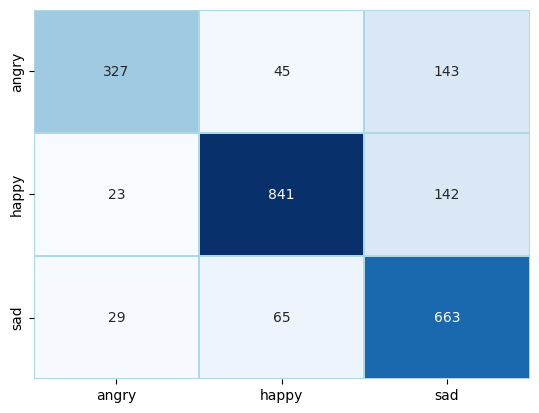

In [ ]:
plot_confusion_matrix(model, valid_dataset_fetch, class_names)

### MobileNetV2

In [ ]:
# Zbior treningowy i waidacyjny istenieje w katalogach
base_path = os.getcwd()
train_directory = os.path.join(base_path, "Emotions Dataset", 'train')
val_directory = os.path.join(base_path, "Emotions Dataset", 'test')
CLASS_NAMES = ['angry','happy','sad']


train_dataset = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                            label_mode='categorical',
                                                            class_names=CLASS_NAMES, #mozna podac w inne kolejnosci, ale nazwy musza byc te same
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                            shuffle=True,
                                                            seed=99
                                                            )

valid_dataset = tf.keras.utils.image_dataset_from_directory(directory=val_directory,
                                                            label_mode='categorical',
                                                            class_names=CLASS_NAMES, #mozna podac w inne kolejnosci, ale nazwy musza byc te same
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                            shuffle=True,
                                                            seed=99
                                                            )



for batch in valid_dataset.take(1):
    print('Images shapes: ', batch[0].shape)
    print('Labels shapes: ', batch[1].shape)

resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
    Rescaling(1./255)
], name='resize_and_rescale')

def resize_rescale(img, label):
    return resize_rescale_layers(img), label

class_names = train_dataset.class_names
train_dataset_fetch = train_dataset.map(resize_rescale).prefetch(tf.data.AUTOTUNE)
valid_dataset_fetch = valid_dataset.map(resize_rescale).prefetch(tf.data.AUTOTUNE)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.
Images shapes:  (32, 200, 200, 3)
Labels shapes:  (32, 3)


In [ ]:
class CustomConv(Layer):
    def __init__(self, name, out_channels, kernel_size, strides):
        super().__init__(name=name)
        self.conv = Conv2D(filters=out_channels, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)
        self.batch_normal = BatchNormalization()
        self.activation = Activation('relu')

    def call(self, x):
        input_shape = x.shape
        x = self.conv(x)
        x = self.batch_normal(x)
        x = self.activation(x)
        output_shape = x.shape
        # print(f'{self.name}: {input_shape} -> {output_shape}')
        return x

class Expansion_block(Layer):
    def __init__(self, name, t, filters):
        super().__init__(name=name)
        self.conv = Conv2D(filters=t*filters, kernel_size=1, padding='same', use_bias=False)
        self.batch_normal = BatchNormalization()
        self.activation = Activation('relu')

    def call(self, x):
        x = self.conv(x)
        x = self.batch_normal(x)
        x = self.activation(x)
        return x

class DepthWise_block(Layer):
    def __init__(self, name, strides=1):
        super().__init__(name=name)
        self.custom_depth = DepthwiseConv2D(kernel_size=3, strides=(strides, strides), padding='same', use_bias=False)
        self.batch_normal = BatchNormalization()
        self.activation = Activation('relu')

    def call(self, x):
        x = self.custom_depth(x)
        x = self.batch_normal(x)
        x = self.activation(x)
        return x

class Projection_block(Layer):
    def __init__(self, name, out_channels):
        super().__init__(name=name)
        self.conv = Conv2D(filters=out_channels,kernel_size=1, padding='same', use_bias=False)
        self.batch_normal = BatchNormalization()

    def call(self, x):
        x = self.conv(x)
        x = self.batch_normal(x)
        return x


class Bottlenect(Layer):
    def __init__(self, name, t, filters, out_channels, strides):
        super().__init__(name=name)
        self.expansion_block = Expansion_block(name='eb', t=t, filters=filters)
        self.depth_depth = DepthWise_block(name='dw', strides=strides)
        self.project_conv = Projection_block(name='pb', out_channels=out_channels)

    def call(self, input_):
        input_shape = input_.shape
        x = self.expansion_block(input_)
        x = self.depth_depth(x)
        x = self.project_conv(x)
        if input_.shape[-1] == x.shape[-1]:
            x = Add()([x, input_])
        output_shape = x.shape
        # print(f'{self.name}: {input_shape} -> {output_shape}')
        return x


class MobileNetV2(Model):
    def __init__(self, name, n_classes):
        super().__init__(name=name)
        #shape = (224, 224, 3)
        self.custom_conv1 = CustomConv(name='cc_1', out_channels=32, kernel_size=(3,3), strides=(2, 2))
        #shape = (112, 112, 32)
        self.bottle1 = Bottlenect(name='bottle1', t=1, filters=32, out_channels=16, strides=1)
        #shape = (112, 112, 16)
        self.bottle2_1 = Bottlenect(name='bottle2_1', t=6, filters=16, out_channels=24, strides=2)
        self.bottle2_2 = Bottlenect(name='bottle2_2', t=6, filters=24, out_channels=24, strides=1)
        #shape = (56, 56, 24)
        self.bottle3_1 = Bottlenect(name='bottle3_1', t=6, filters=24, out_channels=32, strides=2)
        self.bottle3_2 = Bottlenect(name='bottle3_2', t=6, filters=32, out_channels=32, strides=1)
        self.bottle3_3 = Bottlenect(name='bottle3_3', t=6, filters=32, out_channels=32, strides=1)
        #shape = (28, 28, 32)
        self.bottle4_1 = Bottlenect(name='bottle4_1', t=6, filters=32, out_channels=64, strides=2)
        self.bottle4_2 = Bottlenect(name='bottle4_2', t=6, filters=64, out_channels=64, strides=1)
        self.bottle4_3 = Bottlenect(name='bottle4_3', t=6, filters=64, out_channels=64, strides=1)
        self.bottle4_4 = Bottlenect(name='bottle4_4', t=6, filters=64, out_channels=64, strides=1)
        #shape = (14, 14, 64)
        self.bottle5_1 = Bottlenect(name='bottle5_1', t=6, filters=64, out_channels=96, strides=1)
        self.bottle5_2 = Bottlenect(name='bottle5_2', t=6, filters=96, out_channels=96, strides=1)
        self.bottle5_3 = Bottlenect(name='bottle5_3', t=6, filters=96, out_channels=96, strides=1)
        #shape = (14, 14, 96)
        self.bottle6_1 = Bottlenect(name='bottle6_1', t=6, filters=96, out_channels=160, strides=2)
        self.bottle6_2 = Bottlenect(name='bottle6_2', t=6, filters=160, out_channels=160, strides=1)
        self.bottle6_3 = Bottlenect(name='bottle6_3', t=6, filters=160, out_channels=160, strides=1)
        #shape = (7, 7, 160)
        self.bottle7_1 = Bottlenect(name='bottle7_1', t=6, filters=160, out_channels=320, strides=1)
        #shape = (7, 7, 320)
        self.custom_conv2 = CustomConv(name='cc_2', out_channels=1280, kernel_size=(1,1), strides=1)
        #shape = (7, 7, 1280)
        self.global_avarage_pol = GlobalAvgPool2D(name='global_avg_pool')
        #shape = (1, 1, 1280)
        self.output_dense = Dense(units=n_classes, activation='relu')

    def call(self, x):
        # print(x.shape)
        x = self.custom_conv1(x)
        # print('------------')
        x = self.bottle1(x)
        # print('------------')
        x = self.bottle2_1(x)
        x = self.bottle2_2(x)
        # print('------------')
        x = self.bottle3_1(x)
        x = self.bottle3_2(x)
        x = self.bottle3_3(x)
        # print('------------')
        x = self.bottle4_1(x)
        x = self.bottle4_2(x)
        x = self.bottle4_3(x)
        x = self.bottle4_4(x)
        # print('------------')
        x = self.bottle5_1(x)
        x = self.bottle5_2(x)
        x = self.bottle5_3(x)
        # print('------------')
        x = self.bottle6_1(x)
        x = self.bottle6_2(x)
        x = self.bottle6_3(x)
        # print('------------')
        x = self.bottle7_1(x)
        # print('------------')
        x = self.custom_conv2(x)
        x = self.global_avarage_pol(x)
        x = self.output_dense(x)
        # print(x.shape)
        return x




In [ ]:
input_ = Input(shape=(CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3))
mobile_net_v2 = MobileNetV2(name='MobileNetV2', n_classes=CONFIG.NUM_CLASSES)
mobile_net_v2(input_)
mobile_net_v2.summary()




Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cc_1 (CustomConv)           multiple                  992       
                                                                 
 bottle1 (Bottlenect)        multiple                  2144      
                                                                 
 bottle2_1 (Bottlenect)      multiple                  5568      
                                                                 
 bottle2_2 (Bottlenect)      multiple                  9456      
                                                                 
 bottle3_1 (Bottlenect)      multiple                  10640     
                                                                 
 bottle3_2 (Bottlenect)      multiple                  15680     
                                                                 
 bottle3_3 (Bottlenect)      multiple                  

In [ ]:
loss_function = CategoricalCrossentropy()
metrics = CategoricalAccuracy(name='accuracy')

mobile_net_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE),
                      loss=loss_function,
                      metrics=[metrics])

mobile_net_v2.fit(train_dataset_fetch,
                  epochs=CONFIG.N_EPOCHS,
                  validation_data=valid_dataset_fetch,
                  callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='best_model_mobilenetV2',
                                                                monitor='val_accuracy',
                                                                save_best_only=True)])

Epoch 1/60


213/213 [==============================] - ETA: 0s - loss: 1.1006 - accuracy: 0.4764INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


213/213 [==============================] - 645s 3s/step - loss: 1.1006 - accuracy: 0.4764 - val_loss: 1.5424 - val_accuracy: 0.3323
Epoch 2/60
213/213 [==============================] - 617s 3s/step - loss: 0.9738 - accuracy: 0.5433 - val_loss: 4.2373 - val_accuracy: 0.3323
Epoch 3/60
213/213 [==============================] - ETA: 0s - loss: 0.9427 - accuracy: 0.5586INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


213/213 [==============================] - 636s 3s/step - loss: 0.9427 - accuracy: 0.5586 - val_loss: 1.2169 - val_accuracy: 0.4680
Epoch 4/60
213/213 [==============================] - 662s 3s/step - loss: 0.9529 - accuracy: 0.5614 - val_loss: 1.0951 - val_accuracy: 0.4416
Epoch 5/60
213/213 [==============================] - 665s 3s/step - loss: 0.9554 - accuracy: 0.5538 - val_loss: 1.1354 - val_accuracy: 0.4552
Epoch 6/60
213/213 [==============================] - ETA: 0s - loss: 0.8682 - accuracy: 0.6248INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


213/213 [==============================] - 684s 3s/step - loss: 0.8682 - accuracy: 0.6248 - val_loss: 0.8569 - val_accuracy: 0.6036
Epoch 7/60
213/213 [==============================] - 665s 3s/step - loss: 0.7874 - accuracy: 0.6625 - val_loss: 1.0648 - val_accuracy: 0.5922
Epoch 8/60
213/213 [==============================] - 666s 3s/step - loss: 0.7516 - accuracy: 0.6866 - val_loss: 0.9328 - val_accuracy: 0.5707
Epoch 9/60
213/213 [==============================] - 662s 3s/step - loss: 0.8891 - accuracy: 0.5874 - val_loss: 1.7686 - val_accuracy: 0.5224
Epoch 10/60
213/213 [==============================] - 669s 3s/step - loss: 0.8782 - accuracy: 0.6164 - val_loss: 1.1077 - val_accuracy: 0.5637
Epoch 11/60
213/213 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.6897INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


213/213 [==============================] - 683s 3s/step - loss: 0.7749 - accuracy: 0.6897 - val_loss: 0.8368 - val_accuracy: 0.6238
Epoch 12/60
213/213 [==============================] - 673s 3s/step - loss: 0.7095 - accuracy: 0.7158 - val_loss: 2.2364 - val_accuracy: 0.4873
Epoch 13/60
213/213 [==============================] - 673s 3s/step - loss: 0.7481 - accuracy: 0.6939 - val_loss: 6.4617 - val_accuracy: 0.2252
Epoch 14/60
213/213 [==============================] - 676s 3s/step - loss: 0.8826 - accuracy: 0.5823 - val_loss: 1.3832 - val_accuracy: 0.5803
Epoch 15/60
213/213 [==============================] - 674s 3s/step - loss: 0.7900 - accuracy: 0.6489 - val_loss: 1.6051 - val_accuracy: 0.5408
Epoch 16/60
213/213 [==============================] - 674s 3s/step - loss: 0.8110 - accuracy: 0.6354 - val_loss: 0.9407 - val_accuracy: 0.5593
Epoch 17/60
213/213 [==============================] - ETA: 0s - loss: 0.7723 - accuracy: 0.6608INFO:tensorflow:Assets written to: best_model_mobile

INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


213/213 [==============================] - 694s 3s/step - loss: 0.7723 - accuracy: 0.6608 - val_loss: 0.8360 - val_accuracy: 0.6396
Epoch 18/60
213/213 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.7122INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


213/213 [==============================] - 688s 3s/step - loss: 0.6850 - accuracy: 0.7122 - val_loss: 0.7433 - val_accuracy: 0.6813
Epoch 19/60
213/213 [==============================] - 676s 3s/step - loss: 0.6123 - accuracy: 0.7445 - val_loss: 0.8938 - val_accuracy: 0.6585
Epoch 20/60
213/213 [==============================] - ETA: 0s - loss: 0.5897 - accuracy: 0.7667INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


213/213 [==============================] - 694s 3s/step - loss: 0.5897 - accuracy: 0.7667 - val_loss: 1.0904 - val_accuracy: 0.6870
Epoch 21/60
213/213 [==============================] - 678s 3s/step - loss: 0.6743 - accuracy: 0.7351 - val_loss: 1.0522 - val_accuracy: 0.6484
Epoch 22/60
213/213 [==============================] - 678s 3s/step - loss: 0.6071 - accuracy: 0.7642 - val_loss: 0.9636 - val_accuracy: 0.5457
Epoch 23/60
213/213 [==============================] - 679s 3s/step - loss: 0.7727 - accuracy: 0.6808 - val_loss: 1.2809 - val_accuracy: 0.4377
Epoch 24/60
213/213 [==============================] - 678s 3s/step - loss: 0.9418 - accuracy: 0.5605 - val_loss: 0.9684 - val_accuracy: 0.5268
Epoch 25/60
213/213 [==============================] - 680s 3s/step - loss: 0.7978 - accuracy: 0.6532 - val_loss: 0.7822 - val_accuracy: 0.6532
Epoch 26/60
213/213 [==============================] - 680s 3s/step - loss: 0.6907 - accuracy: 0.7072 - val_loss: 0.9190 - val_accuracy: 0.6207
Epoc

INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


213/213 [==============================] - 698s 3s/step - loss: 0.5466 - accuracy: 0.7901 - val_loss: 0.8355 - val_accuracy: 0.7410
Epoch 30/60
213/213 [==============================] - 674s 3s/step - loss: 0.6826 - accuracy: 0.7164 - val_loss: 1.5511 - val_accuracy: 0.5294
Epoch 31/60
213/213 [==============================] - 675s 3s/step - loss: 0.6143 - accuracy: 0.7531 - val_loss: 0.7121 - val_accuracy: 0.7147
Epoch 32/60
213/213 [==============================] - 677s 3s/step - loss: 0.5704 - accuracy: 0.7797 - val_loss: 2.7160 - val_accuracy: 0.5711
Epoch 33/60
213/213 [==============================] - 678s 3s/step - loss: 0.4961 - accuracy: 0.7988 - val_loss: 1.1261 - val_accuracy: 0.6725
Epoch 34/60
213/213 [==============================] - 678s 3s/step - loss: 0.5557 - accuracy: 0.7895 - val_loss: 0.9357 - val_accuracy: 0.7230
Epoch 35/60
213/213 [==============================] - 679s 3s/step - loss: 0.8595 - accuracy: 0.6030 - val_loss: 1.0612 - val_accuracy: 0.5206
Epoc

INFO:tensorflow:Assets written to: best_model_mobilenetV2\assets


213/213 [==============================] - 697s 3s/step - loss: 0.5016 - accuracy: 0.8145 - val_loss: 0.8737 - val_accuracy: 0.7419
Epoch 54/60
213/213 [==============================] - 678s 3s/step - loss: 0.4262 - accuracy: 0.8441 - val_loss: 0.7760 - val_accuracy: 0.7318
Epoch 55/60
213/213 [==============================] - 677s 3s/step - loss: 0.4500 - accuracy: 0.8332 - val_loss: 0.9429 - val_accuracy: 0.6677
Epoch 56/60
213/213 [==============================] - 677s 3s/step - loss: 0.4538 - accuracy: 0.8369 - val_loss: 0.7673 - val_accuracy: 0.7309
Epoch 57/60
213/213 [==============================] - 677s 3s/step - loss: 0.3481 - accuracy: 0.8863 - val_loss: 1.0063 - val_accuracy: 0.7366
Epoch 58/60
213/213 [==============================] - 677s 3s/step - loss: 0.4459 - accuracy: 0.8382 - val_loss: 1.2388 - val_accuracy: 0.6462
Epoch 59/60
213/213 [==============================] - 677s 3s/step - loss: 0.7180 - accuracy: 0.6933 - val_loss: 1.0121 - val_accuracy: 0.4750
Epoc

In [ ]:
mobile_net_v2 = tf.keras.models.load_model('best_model_mobilenetV2')

In [ ]:
mobile_net_v2.evaluate(valid_dataset_fetch)

72/72 [==============================] - 51s 676ms/step - loss: 0.8737 - accuracy: 0.7419


[0.8736744523048401, 0.741878867149353]

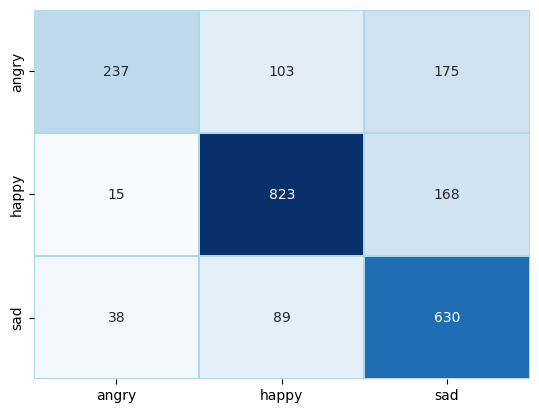

In [ ]:
plot_confusion_matrix(mobile_net_v2, valid_dataset_fetch, class_names)

In [ ]:
mobile_net_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE / 10),
                      loss=loss_function,
                      metrics=[metrics])

mobile_net_v2.fit(train_dataset_fetch,
                  epochs=10,
                  validation_data=valid_dataset_fetch,
                  callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='best_model_mobilenetV2_2',
                                                                monitor='val_accuracy',
                                                                save_best_only=True)])

Epoch 1/10
213/213 [==============================] - ETA: 0s - loss: 0.3124 - accuracy: 0.8370INFO:tensorflow:Assets written to: best_model_mobilenetV2_2\assets


INFO:tensorflow:Assets written to: best_model_mobilenetV2_2\assets


213/213 [==============================] - 657s 3s/step - loss: 0.3124 - accuracy: 0.8370 - val_loss: 0.7589 - val_accuracy: 0.7726
Epoch 2/10
213/213 [==============================] - ETA: 0s - loss: 0.2652 - accuracy: 0.9135INFO:tensorflow:Assets written to: best_model_mobilenetV2_2\assets


INFO:tensorflow:Assets written to: best_model_mobilenetV2_2\assets


213/213 [==============================] - 659s 3s/step - loss: 0.2652 - accuracy: 0.9135 - val_loss: 0.7673 - val_accuracy: 0.7766
Epoch 3/10
213/213 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.9141INFO:tensorflow:Assets written to: best_model_mobilenetV2_2\assets


INFO:tensorflow:Assets written to: best_model_mobilenetV2_2\assets


213/213 [==============================] - 671s 3s/step - loss: 0.2640 - accuracy: 0.9141 - val_loss: 0.7193 - val_accuracy: 0.7853
Epoch 4/10
213/213 [==============================] - 664s 3s/step - loss: 0.2328 - accuracy: 0.9294 - val_loss: 0.7620 - val_accuracy: 0.7853
Epoch 5/10
213/213 [==============================] - 669s 3s/step - loss: 0.2111 - accuracy: 0.9350 - val_loss: 1.0587 - val_accuracy: 0.7445
Epoch 6/10
213/213 [==============================] - 670s 3s/step - loss: 0.2855 - accuracy: 0.9095 - val_loss: 0.7715 - val_accuracy: 0.7823
Epoch 7/10
213/213 [==============================] - 671s 3s/step - loss: 0.2210 - accuracy: 0.9295 - val_loss: 0.7692 - val_accuracy: 0.7840
Epoch 8/10
213/213 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9391INFO:tensorflow:Assets written to: best_model_mobilenetV2_2\assets


INFO:tensorflow:Assets written to: best_model_mobilenetV2_2\assets


213/213 [==============================] - 685s 3s/step - loss: 0.2067 - accuracy: 0.9391 - val_loss: 0.8116 - val_accuracy: 0.7862
Epoch 9/10
213/213 [==============================] - 674s 3s/step - loss: 0.1999 - accuracy: 0.9379 - val_loss: 0.8226 - val_accuracy: 0.7862
Epoch 10/10
213/213 [==============================] - 673s 3s/step - loss: 0.2870 - accuracy: 0.9040 - val_loss: 1.6909 - val_accuracy: 0.7054


In [ ]:
mobile_net_v2 = tf.keras.models.load_model('best_model_mobilenetV2_2')
mobile_net_v2.evaluate(valid_dataset_fetch)

72/72 [==============================] - 55s 735ms/step - loss: 0.8116 - accuracy: 0.7862


[0.811625599861145, 0.7862159609794617]

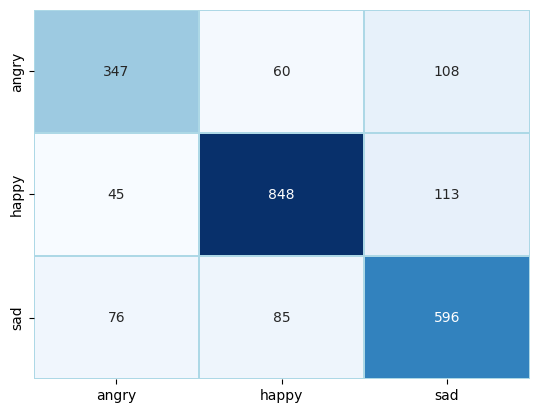

In [ ]:
plot_confusion_matrix(mobile_net_v2, valid_dataset_fetch, class_names)

### TRANSFER LEARNING - EfficientNet

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB4, preprocess_input

backbone = EfficientNetB4(include_top=False,
                            weights='imagenet',
                            input_shape=(CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3),
                            classes = CONFIG.NUM_CLASSES)



In [ ]:
transfer_model = Sequential([
    InputLayer(input_shape=(CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3)),
    backbone,
    GlobalAvgPool2D(),
    Dense(units=CONFIG.N_DENSE_1, activation='relu'),
    BatchNormalization(),
    Dense(units=CONFIG.N_DENSE_2, activation='relu'),
    Dense(units=CONFIG.NUM_CLASSES, activation='softmax'),
])

transfer_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 4, 4, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_24 (Dense)            (None, 1024)              1836032   
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 128)               131200    
                                                     

In [ ]:
# Zbior treningowy i waidacyjny istenieje w katalogach
base_path = os.getcwd()
train_directory = os.path.join(base_path, "Emotions Dataset", 'train')
val_directory = os.path.join(base_path, "Emotions Dataset", 'test')
CLASS_NAMES = ['angry','happy','sad']


train_dataset = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                            label_mode='categorical',
                                                            class_names=CLASS_NAMES, #mozna podac w inne kolejnosci, ale nazwy musza byc te same
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                            shuffle=True,
                                                            seed=99
                                                            )

valid_dataset = tf.keras.utils.image_dataset_from_directory(directory=val_directory,
                                                            label_mode='categorical',
                                                            class_names=CLASS_NAMES, #mozna podac w inne kolejnosci, ale nazwy musza byc te same
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                            shuffle=True,
                                                            seed=99
                                                            )



for batch in valid_dataset.take(1):
    print('Images shapes: ', batch[0].shape)
    print('Labels shapes: ', batch[1].shape)

resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
    Rescaling(1./255)
], name='resize_and_rescale')

def resize_rescale(img, label):
    return tf.keras.applications.resize_rescale_layers(img), label

def preprocess(img, label):
    return preprocess_input(img), label

class_names = train_dataset.class_names
train_dataset_fetch = train_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)
valid_dataset_fetch = valid_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)


Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.
Images shapes:  (32, 100, 100, 3)
Labels shapes:  (32, 3)


In [ ]:
loss_function = CategoricalCrossentropy()
metrics = CategoricalAccuracy(name='accuracy')

backbone.trainable = False

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE),
                      loss=loss_function,
                      metrics=[metrics])

history = transfer_model.fit(train_dataset_fetch,
                            epochs=10,
                            validation_data=valid_dataset_fetch,
                            callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='best_model_transfer',
                                                                            monitor='val_accuracy',
                                                                            save_best_only=True)])

Epoch 1/10
213/213 [==============================] - ETA: 0s - loss: 0.9088 - accuracy: 0.6383INFO:tensorflow:Assets written to: best_model_transfer\assets


INFO:tensorflow:Assets written to: best_model_transfer\assets


213/213 [==============================] - 181s 788ms/step - loss: 0.9088 - accuracy: 0.6383 - val_loss: 0.7136 - val_accuracy: 0.6813
Epoch 2/10
213/213 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.7382INFO:tensorflow:Assets written to: best_model_transfer\assets


INFO:tensorflow:Assets written to: best_model_transfer\assets


213/213 [==============================] - 156s 732ms/step - loss: 0.6209 - accuracy: 0.7382 - val_loss: 0.7051 - val_accuracy: 0.7015
Epoch 3/10
213/213 [==============================] - ETA: 0s - loss: 0.5384 - accuracy: 0.7750INFO:tensorflow:Assets written to: best_model_transfer\assets


INFO:tensorflow:Assets written to: best_model_transfer\assets


213/213 [==============================] - 164s 771ms/step - loss: 0.5384 - accuracy: 0.7750 - val_loss: 0.6017 - val_accuracy: 0.7467
Epoch 4/10
213/213 [==============================] - 117s 549ms/step - loss: 0.4628 - accuracy: 0.8153 - val_loss: 0.6651 - val_accuracy: 0.7349
Epoch 5/10
213/213 [==============================] - ETA: 0s - loss: 0.4389 - accuracy: 0.8222INFO:tensorflow:Assets written to: best_model_transfer\assets


INFO:tensorflow:Assets written to: best_model_transfer\assets


213/213 [==============================] - 169s 795ms/step - loss: 0.4389 - accuracy: 0.8222 - val_loss: 0.5766 - val_accuracy: 0.7730
Epoch 6/10
213/213 [==============================] - ETA: 0s - loss: 0.4094 - accuracy: 0.8364INFO:tensorflow:Assets written to: best_model_transfer\assets


INFO:tensorflow:Assets written to: best_model_transfer\assets


213/213 [==============================] - 171s 803ms/step - loss: 0.4094 - accuracy: 0.8364 - val_loss: 0.5717 - val_accuracy: 0.7774
Epoch 7/10
213/213 [==============================] - 118s 556ms/step - loss: 0.3640 - accuracy: 0.8525 - val_loss: 0.6246 - val_accuracy: 0.7625
Epoch 8/10
213/213 [==============================] - 118s 553ms/step - loss: 0.3491 - accuracy: 0.8620 - val_loss: 0.6368 - val_accuracy: 0.7691
Epoch 9/10
213/213 [==============================] - 118s 552ms/step - loss: 0.3281 - accuracy: 0.8688 - val_loss: 0.6872 - val_accuracy: 0.7700
Epoch 10/10
213/213 [==============================] - ETA: 0s - loss: 0.2972 - accuracy: 0.8859INFO:tensorflow:Assets written to: best_model_transfer\assets


INFO:tensorflow:Assets written to: best_model_transfer\assets


213/213 [==============================] - 174s 818ms/step - loss: 0.2972 - accuracy: 0.8859 - val_loss: 0.6356 - val_accuracy: 0.7796


FINETUNING

In [ ]:
backbone.trainable = True

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE/100),
                      loss=loss_function,
                      metrics=[metrics])

history = transfer_model.fit(train_dataset_fetch,
                            epochs=3,
                            validation_data=valid_dataset_fetch,
                            callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='best_model_transfer',
                                                                            monitor='val_accuracy',
                                                                            save_best_only=True)])


Epoch 1/3
213/213 [==============================] - ETA: 0s - loss: 1.9347 - accuracy: 0.5696INFO:tensorflow:Assets written to: best_model_transfer\assets


INFO:tensorflow:Assets written to: best_model_transfer\assets


213/213 [==============================] - 539s 2s/step - loss: 1.9347 - accuracy: 0.5696 - val_loss: 1.7188 - val_accuracy: 0.5558
Epoch 2/3
213/213 [==============================] - 420s 2s/step - loss: 1.4144 - accuracy: 0.5836 - val_loss: 1.7530 - val_accuracy: 0.5483
Epoch 3/3
213/213 [==============================] - ETA: 0s - loss: 1.1696 - accuracy: 0.6241

### TRANSFER LEARNING - VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_dataset = train_generator.flow_from_directory(train_directory,
                                                    target_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                    batch_size=32)

valid_dataset = valid_generator.flow_from_directory(val_directory,
                                                    target_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                    batch_size=32)

base_model = VGG16(include_top=False, input_shape=(CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3), classes=CONFIG.NUM_CLASSES)
base_model.trainable = False

transfer_model = Sequential([
    InputLayer(input_shape=(CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3)),
    base_model,
    GlobalAvgPool2D(),
    Dense(units=CONFIG.N_DENSE_1, activation='relu'),
    BatchNormalization(),
    Dense(units=CONFIG.N_DENSE_2, activation='relu'),
    Dense(units=CONFIG.NUM_CLASSES, activation='softmax'),
])

transfer_model.summary()

loss_function = CategoricalCrossentropy()
metrics = CategoricalAccuracy(name='accuracy')

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE),
                      loss=loss_function,
                      metrics=[metrics])

history = transfer_model.fit(train_dataset,
                            epochs=10,
                            validation_data=valid_dataset,
                            callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='best_model_transfer_vgg16',
                                                                            monitor='val_accuracy',
                                                                            save_best_only=True)])


Found 6799 images belonging to 3 classes.
Found 2278 images belonging to 3 classes.
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 1024)              525312    
                                                                 
 batch_normalization_7 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_28 (Dense)            (None, 128)               131200    
                                   

INFO:tensorflow:Assets written to: best_model_transfer_vgg16\assets


213/213 [==============================] - 171s 796ms/step - loss: 0.8157 - accuracy: 0.6827 - val_loss: 0.6991 - val_accuracy: 0.7155
Epoch 2/10
213/213 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.8017INFO:tensorflow:Assets written to: best_model_transfer_vgg16\assets


INFO:tensorflow:Assets written to: best_model_transfer_vgg16\assets


213/213 [==============================] - 169s 794ms/step - loss: 0.4839 - accuracy: 0.8017 - val_loss: 0.6449 - val_accuracy: 0.7537
Epoch 3/10
213/213 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.8473INFO:tensorflow:Assets written to: best_model_transfer_vgg16\assets


INFO:tensorflow:Assets written to: best_model_transfer_vgg16\assets


213/213 [==============================] - 169s 795ms/step - loss: 0.3853 - accuracy: 0.8473 - val_loss: 0.6431 - val_accuracy: 0.7761
Epoch 4/10
213/213 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.8766INFO:tensorflow:Assets written to: best_model_transfer_vgg16\assets


INFO:tensorflow:Assets written to: best_model_transfer_vgg16\assets


213/213 [==============================] - 171s 803ms/step - loss: 0.3225 - accuracy: 0.8766 - val_loss: 0.6095 - val_accuracy: 0.7902
Epoch 5/10
213/213 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.8948INFO:tensorflow:Assets written to: best_model_transfer_vgg16\assets


INFO:tensorflow:Assets written to: best_model_transfer_vgg16\assets


213/213 [==============================] - 170s 797ms/step - loss: 0.2781 - accuracy: 0.8948 - val_loss: 0.6583 - val_accuracy: 0.7915
Epoch 6/10
213/213 [==============================] - ETA: 0s - loss: 0.2476 - accuracy: 0.9070INFO:tensorflow:Assets written to: best_model_transfer_vgg16\assets


INFO:tensorflow:Assets written to: best_model_transfer_vgg16\assets


213/213 [==============================] - 171s 803ms/step - loss: 0.2476 - accuracy: 0.9070 - val_loss: 0.6906 - val_accuracy: 0.7976
Epoch 7/10
213/213 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9263INFO:tensorflow:Assets written to: best_model_transfer_vgg16\assets


INFO:tensorflow:Assets written to: best_model_transfer_vgg16\assets


213/213 [==============================] - 171s 806ms/step - loss: 0.2012 - accuracy: 0.9263 - val_loss: 0.6805 - val_accuracy: 0.8060
Epoch 8/10
213/213 [==============================] - 165s 775ms/step - loss: 0.1842 - accuracy: 0.9306 - val_loss: 0.7450 - val_accuracy: 0.8007
Epoch 9/10
213/213 [==============================] - 170s 799ms/step - loss: 0.1799 - accuracy: 0.9338 - val_loss: 0.7797 - val_accuracy: 0.8033
Epoch 10/10
213/213 [==============================] - 169s 794ms/step - loss: 0.1727 - accuracy: 0.9382 - val_loss: 0.7232 - val_accuracy: 0.7968


### VISUALIZING LAYERS

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

vgg_backbone = VGG16(include_top=False,
                     input_shape=(CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3))

vgg_backbone.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

In [ ]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if isinstance(layer, Conv2D)]

print(len(feature_maps))

feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
)

feature_map_model.summary()

13
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0

                                                                 
 block4_conv3 (Conv2D)       (None, 12, 12, 512)       2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 6, 6, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 14714688 (56.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
img_paths = glob.glob(f'{val_directory}\\**\\*.jp*g')
images = [(path, pathlib.Path(path).parts[-2]) for path in img_paths]

plt.figure(figsize=(10,10))
foto_idx = 124
img, lab = images[foto_idx]
img_array = cv2.imread(img)
img_array = cv2.resize(img_array, dsize=(CONFIG.IM_SIZE, CONFIG.IM_SIZE))
img_array = np.expand_dims(img_array, 0)
f_maps = feature_map_model.predict(img_array)

for fmap in f_maps:
    print(fmap.shape)


1/1 [==============================] - 0s 99ms/step
(1, 100, 100, 64)
(1, 100, 100, 64)
(1, 50, 50, 128)
(1, 50, 50, 128)
(1, 25, 25, 256)
(1, 25, 25, 256)
(1, 25, 25, 256)
(1, 12, 12, 512)
(1, 12, 12, 512)
(1, 12, 12, 512)
(1, 6, 6, 512)
(1, 6, 6, 512)
(1, 6, 6, 512)


<Figure size 1000x1000 with 0 Axes>

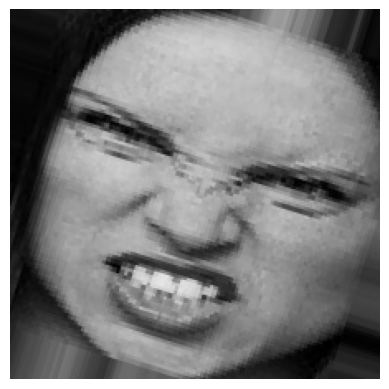

In [ ]:
plt.imshow(cv2.imread(images[foto_idx][0]))
plt.axis('off')

number_of_maps = len(f_maps)

plt.figure(figsize=(100, 100))
for idx in range(number_of_maps):
    f_map = f_maps[idx]
    n_channels = f_map.shape[-1]
    f_size = f_map.shape[1]
    img = f_map[:,:,:,0][0]
    for i in range(1,20):
        next_img = f_map[:,:,:,i][0]
        img = np.concatenate([img, next_img], axis=1)

    plt.subplot(number_of_maps, 1, idx+1)
    plt.imshow(img, cmap='gray_r')
    plt.axis('off')

### GRAD-CAM

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_dataset = train_generator.flow_from_directory(train_directory,
                                                    target_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                    batch_size=32)

valid_dataset = valid_generator.flow_from_directory(val_directory,
                                                    target_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                    batch_size=32)

Found 6799 images belonging to 3 classes.
Found 2278 images belonging to 3 classes.


In [ ]:
base_model = VGG16(include_top=False, input_shape=(CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3), classes=CONFIG.NUM_CLASSES)
base_model.trainable = False
last_layer = base_model.layers[-1].name

x = base_model.output
x = GlobalAvgPool2D()(x)
x = Dense(units=CONFIG.N_DENSE_1, activation='relu')(x)
x = Dense(units=CONFIG.N_DENSE_2, activation='relu')(x)
output = Dense(units=CONFIG.NUM_CLASSES, activation='softmax')(x)

pretrained_model = Model(base_model.inputs, output)
pretrained_model.summary()


loss_function = CategoricalCrossentropy()
metrics = CategoricalAccuracy(name='accuracy')

pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE),
                      loss=loss_function,
                      metrics=[metrics])


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

In [ ]:

history = pretrained_model.fit(train_dataset,
                            epochs=10,
                            validation_data=valid_dataset,
                            callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='best_model_transfer_vgg16.h5',
                                                                            monitor='val_accuracy',
                                                                            save_best_only=True,
                                                                            save_weights_only=True)])

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

In [ ]:
pretrained_model.load_weights('best_model_transfer_vgg16.h5')
# pretrained_model.evaluate(valid_dataset)

(-0.5, 223.5, 223.5, -0.5)

<Figure size 1000x1000 with 0 Axes>

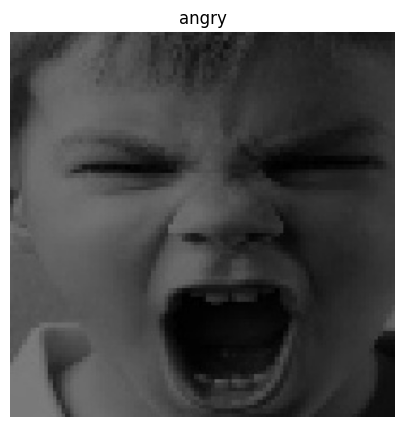

In [ ]:
img_paths = glob.glob(f'{val_directory}\\**\\*.jp*g')
images = [(path, pathlib.Path(path).parts[-2]) for path in img_paths]

plt.figure(figsize=(10,10))
foto_idx = 345
img, lab = images[foto_idx]
img_array = cv2.imread(img)
img_array = cv2.resize(img_array, dsize=(CONFIG.IM_SIZE, CONFIG.IM_SIZE))
img_array = np.expand_dims(img_array, 0)

plt.figure(figsize=(5, 5))
plt.imshow(cv2.imread(images[foto_idx][0]))
plt.title(images[foto_idx][1])
plt.axis('off')

In [ ]:
pred = pretrained_model.predict(img_array)
np.argmax(pred[0])

1/1 [==============================] - 0s 333ms/step


0

In [ ]:
last_layer = base_model.layers[-1].name

last_conv_layer = pretrained_model.get_layer(last_layer)
print(last_conv_layer.name)

last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)
last_conv_layer_model.summary()

block5_pool
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128

In [ ]:
pretrained_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

In [ ]:
classifier_layer_names = ['global_average_pooling2d',
                          'dense',
                          'dense_1',
                          'dense_2']

classifier_input = Input(shape=last_conv_layer.output.shape[1:])

x = classifier_input
for layer_name in classifier_layer_names:
    x = pretrained_model.get_layer(layer_name)(x)

classifier_model = Model(classifier_input, x)
classifier_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3, 3, 512)]       0         
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 656899 (2.51 MB)
Trainable params: 656899 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [ ]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:,top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)
grads.shape

TensorShape([1, 3, 3, 512])

In [ ]:
#srednia dla każdego kanału
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()

pooled_grads.shape

(512,)

In [ ]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]

for i in range(512):
    last_conv_layer_output[:,:,i] *= pooled_grads[i]



In [ ]:
heatmap = np.sum(last_conv_layer_output, axis=-1)
heatmap.shape

(3, 3)

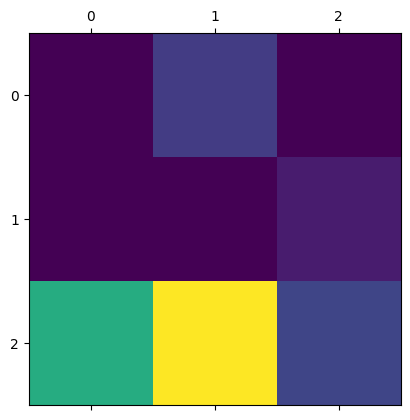

In [ ]:
heatmap = tf.nn.relu(heatmap)
plt.matshow(heatmap)

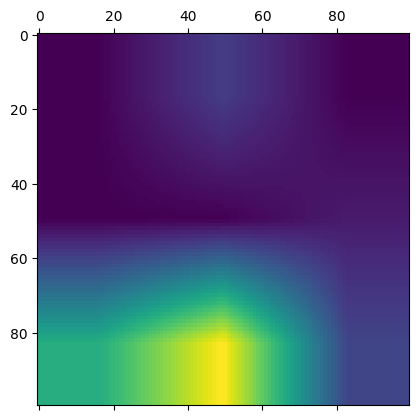

In [ ]:
resized_heatmap = cv2.resize(np.array(heatmap), (CONFIG.IM_SIZE, CONFIG.IM_SIZE))
plt.matshow(resized_heatmap)

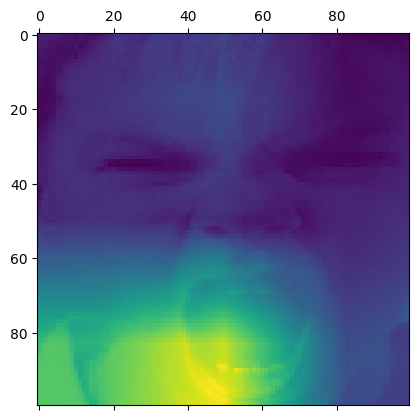

In [ ]:

plt.matshow(resized_heatmap*100 + img_array[0,:,:,0]/255)

GRAD CAM

In [ ]:
# convolution model
base_model = VGG16(include_top=False, input_shape=(CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3), classes=CONFIG.NUM_CLASSES)
base_model.trainable = False


# classifier model
input_ = Input(shape=base_model.output.shape[1:])
x = GlobalAvgPool2D()(input_)
x = Dense(units=CONFIG.N_DENSE_1, activation='relu')(x)
x = Dense(units=CONFIG.N_DENSE_2, activation='relu')(x)
output = Dense(units=CONFIG.NUM_CLASSES, activation='softmax')(x)
classifier_model = Model(inputs=input_, outputs=output, name='classifier_model')

# final model
x = base_model.inputs
x = base_model(x)
x = classifier_model(x)

pretrained_model = Model(base_model.inputs, x)
pretrained_model.summary()

loss_function = CategoricalCrossentropy()
metrics = CategoricalAccuracy(name='accuracy')

pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE),
                      loss=loss_function,
                      metrics=[metrics])


Model: "model_274"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_141 (InputLayer)      [(None, 100, 100, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 classifier_model (Function  (None, 3)                 656899    
 al)                                                             
                                                                 
Total params: 15371587 (58.64 MB)
Trainable params: 656899 (2.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
history = pretrained_model.fit(train_dataset,
                            epochs=5,
                            validation_data=valid_dataset,
                            callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='best_model_transfer_vgg16.h5',
                                                                            monitor='val_accuracy',
                                                                            save_best_only=True,
                                                                            save_weights_only=True)])

Epoch 1/5
213/213 [==============================] - 194s 905ms/step - loss: 1.0592 - accuracy: 0.6430 - val_loss: 0.7027 - val_accuracy: 0.6967
Epoch 2/5
213/213 [==============================] - 185s 870ms/step - loss: 0.5574 - accuracy: 0.7617 - val_loss: 0.6102 - val_accuracy: 0.7379
Epoch 3/5
213/213 [==============================] - 185s 870ms/step - loss: 0.4382 - accuracy: 0.8204 - val_loss: 0.5977 - val_accuracy: 0.7559
Epoch 4/5
213/213 [==============================] - 183s 859ms/step - loss: 0.3679 - accuracy: 0.8488 - val_loss: 0.6406 - val_accuracy: 0.7748
Epoch 5/5
213/213 [==============================] - 190s 893ms/step - loss: 0.2890 - accuracy: 0.8831 - val_loss: 0.5515 - val_accuracy: 0.8064


In [ ]:
pretrained_model.load_weights('best_model_transfer_vgg16.h5')

pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE/100),
                      loss=loss_function,
                      metrics=[metrics])


history = pretrained_model.fit(train_dataset,
                            epochs=5,
                            validation_data=valid_dataset,
                            callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='best_model_transfer_vgg16.h5',
                                                                            monitor='val_accuracy',
                                                                            save_best_only=True,
                                                                            save_weights_only=True)])


Epoch 1/5
213/213 [==============================] - 172s 804ms/step - loss: 0.1458 - accuracy: 0.9522 - val_loss: 0.5966 - val_accuracy: 0.8086
Epoch 2/5
213/213 [==============================] - 179s 840ms/step - loss: 0.1216 - accuracy: 0.9615 - val_loss: 0.6099 - val_accuracy: 0.8143
Epoch 3/5
213/213 [==============================] - 171s 801ms/step - loss: 0.1101 - accuracy: 0.9662 - val_loss: 0.6212 - val_accuracy: 0.8174
Epoch 4/5
213/213 [==============================] - 170s 797ms/step - loss: 0.1022 - accuracy: 0.9672 - val_loss: 0.6355 - val_accuracy: 0.8200
Epoch 5/5
213/213 [==============================] - 170s 797ms/step - loss: 0.0964 - accuracy: 0.9685 - val_loss: 0.6448 - val_accuracy: 0.8183


(-0.5, 99.5, 99.5, -0.5)

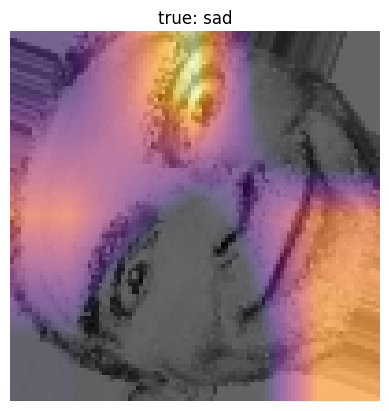

In [ ]:
pretrained_model.load_weights('best_model_transfer_vgg16.h5')

img_paths = glob.glob(f'{val_directory}\\**\\*.jp*g')
images = [(path, pathlib.Path(path).parts[-2]) for path in img_paths]

foto_idx = np.random.randint(0, len(img_paths))
img, lab = images[foto_idx]
img_array = cv2.imread(img)
img_array = cv2.resize(img_array, dsize=(CONFIG.IM_SIZE, CONFIG.IM_SIZE))
img_array = np.expand_dims(img_array, 0)


pretrained_model_conv = Model(inputs=pretrained_model.inputs, outputs=pretrained_model.get_layer(base_model.name).outputs)

x = pretrained_model_conv.output
x = pretrained_model.get_layer(classifier_model.name)(x)

pretrained_model_class = Model(inputs=pretrained_model_conv.output, outputs=x)


with tf.GradientTape() as tape:
    conv_output = pretrained_model_conv(img_array)
    preds = classifier_model(conv_output)
    index = tf.argmax(preds[0])
    class_output = preds[:, index]
    grad = tape.gradient(class_output, conv_output)


reduce_mean_grad = tf.reduce_mean(grad, axis=(0, 1, 2))


conv_output = conv_output[0].numpy()
for i in range(conv_output.shape[-1]):
    mean = reduce_mean_grad[i]
    conv_output[:,:,i] = conv_output[:,:,i] * mean


conv_out_sum = np.sum(conv_output, axis=-1)

resized_map = cv2.resize(conv_out_sum, dsize=(CONFIG.IM_SIZE, CONFIG.IM_SIZE))

resized_map = resized_map / resized_map.max()


colormap = plt.get_cmap('inferno')
heatmap = (colormap(resized_map) * 2**10).astype(np.uint16)[:,:,:3]


heatmap = heatmap - heatmap.min()
heatmap = heatmap / heatmap.max()

img = img_array[0] - img_array[0].min()
img = img/img.max()

result = cv2.addWeighted(img, 0.4, heatmap, 0.6, 0)
plt.imshow(result)
plt.title(f'true: {lab}')
plt.axis('off')







GRAD CAM CLASS

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
# train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
# valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_dataset = train_generator.flow_from_directory(train_directory,
                                                    target_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                    batch_size=32)

valid_dataset = valid_generator.flow_from_directory(val_directory,
                                                    target_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE),
                                                    batch_size=32)

Found 6799 images belonging to 3 classes.
Found 2278 images belonging to 3 classes.


In [ ]:
class GradCamModel(Model):
    def __init__(self, conv_model, class_model, name='GradCamModel'):
        super().__init__(name=name)
        self.conv_model = conv_model
        self.class_model = class_model

    def call(self, input_):
        x = self.conv_model(input_)
        x = self.class_model(x)
        return x

    def grad_cam(self, img_array):
        img_array = tf.expand_dims(img_array, axis=0)
        with tf.GradientTape() as tape:
            conv_output = self.conv_model(img_array)
            preds = self.class_model(conv_output)
            index = tf.argmax(preds, axis=1)
            class_output = preds[:,index[0]]

        grad = tape.gradient(class_output, conv_output)
        reduce_mean_grad = tf.reduce_mean(grad, axis=(0, 1, 2))

        conv_output = conv_output[0].numpy()
        for i in range(len(reduce_mean_grad)):
            conv_output[:,:,i] *= reduce_mean_grad[i]

        conv_out_sum = np.sum(conv_output, axis=-1)
        resized_map = cv2.resize(conv_out_sum, dsize=(CONFIG.IM_SIZE, CONFIG.IM_SIZE))
        resized_map = resized_map / resized_map.max()

        colormap = plt.get_cmap('inferno')
        heatmap = (colormap(resized_map) * 2**16).astype(np.uint16)[:,:,:3]
        heatmap = heatmap - heatmap.min()
        heatmap = heatmap / heatmap.max()

        img_array = img_array.numpy()
        img = img_array[0] - img_array[0].min()
        img = img/img.max()

        result = cv2.addWeighted(img, 0.4, heatmap, 0.6, 0)
        return result



conv_model = Sequential([
    Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.4),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.4),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.4)
])

class_model = Sequential([
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.4),
    Dense(units=3, activation='softmax')
])

custom_model = GradCamModel(conv_model, class_model)
input_ = Input(shape=(CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3))
custom_model(input_)
custom_model.summary()




Model: "GradCamModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_22 (Sequential)  (None, 12, 12, 32)        6032      
                                                                 
 sequential_23 (Sequential)  (None, 3)                 590339    
                                                                 
Total params: 596371 (2.27 MB)
Trainable params: 596371 (2.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
custom_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE),
                     loss = 'categorical_crossentropy',
                     metrics = "accuracy")

custom_model.fit(train_dataset, epochs=40, validation_data=valid_dataset)

Epoch 1/40
213/213 [==============================] - 13s 56ms/step - loss: 1.0869 - accuracy: 0.4402 - val_loss: 1.0780 - val_accuracy: 0.4442
Epoch 2/40
213/213 [==============================] - 12s 55ms/step - loss: 1.0504 - accuracy: 0.4577 - val_loss: 1.0621 - val_accuracy: 0.4838
Epoch 3/40
213/213 [==============================] - 12s 54ms/step - loss: 1.0302 - accuracy: 0.4864 - val_loss: 1.0297 - val_accuracy: 0.5022
Epoch 4/40
213/213 [==============================] - 12s 55ms/step - loss: 0.9902 - accuracy: 0.5233 - val_loss: 0.9638 - val_accuracy: 0.5623
Epoch 5/40
213/213 [==============================] - 12s 54ms/step - loss: 0.9173 - accuracy: 0.5717 - val_loss: 0.8999 - val_accuracy: 0.6128
Epoch 6/40
213/213 [==============================] - 12s 55ms/step - loss: 0.8668 - accuracy: 0.5986 - val_loss: 0.8495 - val_accuracy: 0.6102
Epoch 7/40
213/213 [==============================] - 12s 55ms/step - loss: 0.8181 - accuracy: 0.6277 - val_loss: 0.8035 - val_accuracy:

tf.Tensor([[1.0000000e+00 0.0000000e+00 2.6221114e-11]], shape=(1, 3), dtype=float32)


(-0.5, 99.5, 99.5, -0.5)

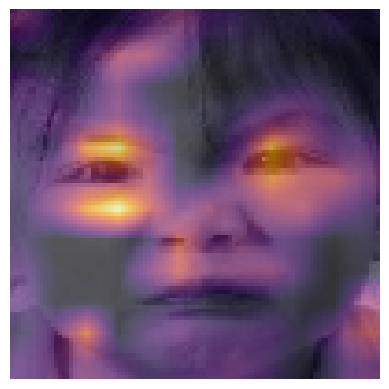

In [ ]:
img_paths = glob.glob(f'{val_directory}\\**\\*.jp*g')
images = [(path, pathlib.Path(path).parts[-2]) for path in img_paths]

foto_idx = np.random.randint(0, len(img_paths))
img, lab = images[foto_idx]
img_array = cv2.imread(img)
img_array = cv2.resize(img_array, dsize=(CONFIG.IM_SIZE, CONFIG.IM_SIZE))

pred = custom_model(tf.expand_dims(img_array, 0))
print(pred)
result = custom_model.grad_cam(img_array)
plt.imshow(result)
plt.axis('off')

### EMBEDING MODEL

In [ ]:
vgg_model = tf.keras.models.load_model('best_model_transfer_vgg16')
eff_model = tf.keras.models.load_model('best_model_transfer_efficient')

In [ ]:

input_ = Input(shape=(CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3))
out1 = vgg_model(input_)
out2 = eff_model(input_)
output = 0.5*out1 + 0.5*out2

emb_model = Model(inputs=input_, outputs=output)

emb_model.summary()

emb_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

emb_model.evaluate(valid_dataset)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 sequential_25 (Sequential)  (None, 3)                    1537568   ['input_24[0][0]']            
                                                          3                                       
                                                                                                  
 sequential_4 (Sequential)   (None, 3)                    1964553   ['input_24[0][0]']            
                                                          8                                       
                                                                                            

[0.7743699550628662, 0.6878840923309326]

### VIT TRANSFORMER

<img src='https://miro.medium.com/v2/resize:fit:1400/1*l37va2Mu8Snx6LLb13430A.png'>

tf.image.extract_patches

In [9]:
import glob

In [10]:
CONFIG.PATCH_SIZE = 16

(1, 100, 100, 3)
(1, 6, 6, 768)


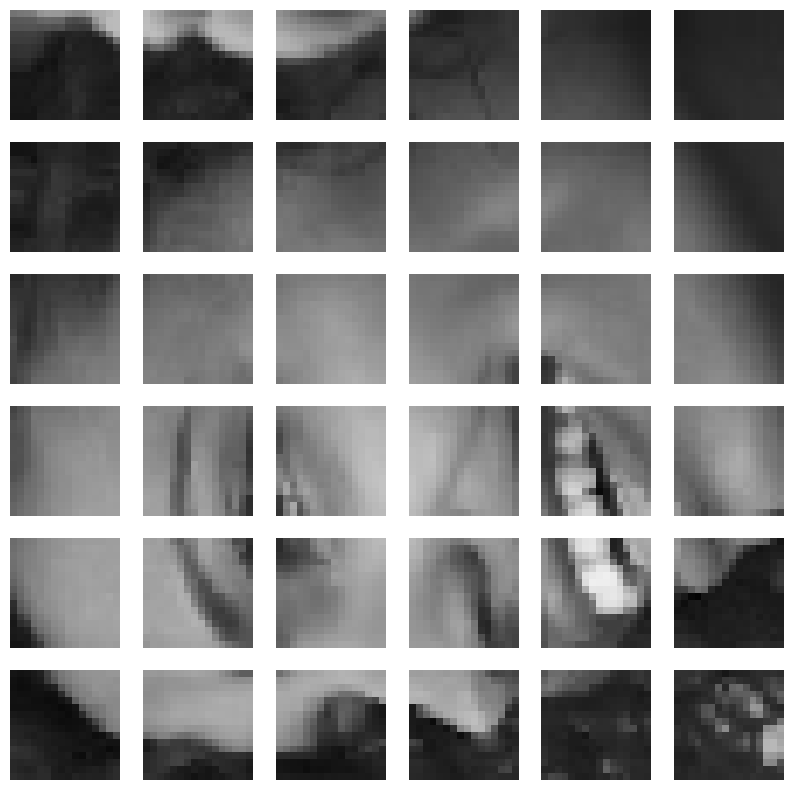

In [11]:
files = glob.glob(train_directory + '\\*\\*.jp*g')

img = files[np.random.randint(0, len(files))]
img_array = cv2.imread(img)
img_array = cv2.resize(img_array, (CONFIG.IM_SIZE, CONFIG.IM_SIZE))
img_array = tf.expand_dims(img_array, axis=0)

print(img_array.shape)

patches = tf.image.extract_patches(img_array, sizes=[1,CONFIG.PATCH_SIZE,CONFIG.PATCH_SIZE,1],
                                                strides=[1,CONFIG.PATCH_SIZE,CONFIG.PATCH_SIZE,1],
                                                rates=[1,1,1,1],
                                                padding='VALID')

print(patches.shape)
k=0
plt.figure(figsize=(10, 10))
for i in range(patches.shape[1]):
    for j in range(patches.shape[2]):
        k+=1
        img_array = patches[0, i, j,:]
        img_array = tf.reshape(img_array, (CONFIG.PATCH_SIZE, CONFIG.PATCH_SIZE, 3))
        plt.subplot(patches.shape[1], patches.shape[2], k)
        plt.imshow(img_array)
        plt.axis('off')
        

# zdjęcie zostalo podzielone na 144 elementy. Kazdy ma 768 pikseli

In [12]:
#zmiana wymiaru zbioru patches 

patches = tf.reshape(patches, (patches.shape[0],-1,patches.shape[-1]))
patches.shape

#kazdy ze 144 elementów bedzie wrzucany do transfomera

TensorShape([1, 36, 768])

tf.keras.layers.Embedding

In [13]:
#zamienia integer na wektor o określonym rozmiarze (output_dim)

model = Sequential()
model.add(tf.keras.layers.Embedding(input_dim=1000, output_dim=64, input_length=10))

input_array = np.random.randint(1000, size=(32, 10))
print(input_array.shape)

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array.shape)

(32, 10)
1/1 [==============================] - 0s 468ms/step
(32, 10, 64)


In [14]:
class PatchEncoder(Layer):
    def __init__(self, N_PATCHES, HIDDEN_SIZE):
        super().__init__(name='patch_encoder')
        self.linear_projection = Dense(HIDDEN_SIZE)
        #warstaw embedding będzie zwiazan z numerowaniem paczek (patches)
        self.positional_embedding = tf.keras.layers.Embedding(N_PATCHES, HIDDEN_SIZE)
        self.N_PATCHES = N_PATCHES
        
    def call(self, x):
        patches = tf.image.extract_patches(x, sizes=[1,CONFIG.PATCH_SIZE,CONFIG.PATCH_SIZE,1],
                                              strides=[1,CONFIG.PATCH_SIZE,CONFIG.PATCH_SIZE,1],
                                              rates=[1,1,1,1],
                                              padding='VALID')
        patches = tf.reshape(patches, (patches.shape[0], -1, patches.shape[-1]))
        embedding_input = tf.range(start=0, limit=self.N_PATCHES, delta=1)
        output = self.linear_projection(patches) + self.positional_embedding(embedding_input)
        return output

In [15]:
patch_encoder = PatchEncoder(144, 768)
patch_encoder(tf.zeros((1, 200, 200, 3))).shape

TensorShape([1, 144, 768])

In [16]:
class TransformerEncoder(Layer):
    def __init__(self, N_HEADS, HIDDEN_SIZE):
        super().__init__(name='transformer_encoder')
        self.layer_norm1 = tf.keras.layers.LayerNormalization()
        self.layer_norm2 = tf.keras.layers.LayerNormalization()
        
        self.multi_head_att = tf.keras.layers.MultiHeadAttention(N_HEADS, HIDDEN_SIZE)
        
        self.dense1 = Dense(HIDDEN_SIZE, activation=tf.nn.gelu)
        self.dense2 = Dense(HIDDEN_SIZE, activation=tf.nn.gelu)
    
    def call(self, input):
        x_1 = self.layer_norm1(input)
        x_1 = self.multi_head_att(x_1, x_1)
        
        x_1 = Add()([x_1, input])
        
        x_2 = self.layer_norm2(x_1)
        x_2 = self.dense1(x_2)
        output = self.dense2(x_2)
        output = Add()([output, x_1])
        
        return output
    
    

In [17]:
trans_enc = TransformerEncoder(8, 768)
trans_enc(tf.zeros([1, 256, 768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [18]:
class ViT(Model):
    def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
        super().__init__(name='vision_transformer')
        self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
        self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
        self.N_LAYERS = N_LAYERS
        self.dense_1 = Dense(N_DENSE_UNITS, activation=tf.nn.gelu)
        self.dense_2 = Dense(N_DENSE_UNITS, activation=tf.nn.gelu)
        self.dense_3 = Dense(CONFIG.NUM_CLASSES, activation='softmax')
        
    def call(self, input):
        x = self.patch_encoder(input)
        for i in range(self.N_LAYERS):
            x = self.trans_encoders[i](x)
 
        x = Flatten()(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        
        return x
        
    

In [19]:
vit = ViT(N_HEADS=4, HIDDEN_SIZE=768, N_PATCHES=144, N_LAYERS=2, N_DENSE_UNITS=128)
vit(tf.zeros((32, 200, 200, 3)))
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncode  multiple                  701184    
 r)                                                              
                                                                 
 transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 dense_8 (Dense)             multiple                  14155904  
                                                                 
 dense_9 (Dense)             multiple                  16512     
                                                

In [20]:
class PatchEncoder(Layer):
    def __init__(self, PATCH_SIZE, N_PATCHES, HIDDEN_SIZE):
        super().__init__(name='Patch_encoder')
        self.PATCH_SIZE = PATCH_SIZE
        self.N_PATCHES = N_PATCHES
        self.positional_embeding = tf.keras.layers.Embedding(self.N_PATCHES, HIDDEN_SIZE)
        self.linear_projection = Dense(units=HIDDEN_SIZE)
        
    def call(self, input_):
        patches = tf.image.extract_patches(input_, sizes=[1,self.PATCH_SIZE,self.PATCH_SIZE,1], 
                                                   strides=[1, self.PATCH_SIZE, self.PATCH_SIZE, 1],
                                                   rates=[1,1,1,1],
                                                   padding='VALID')

        patches = tf.reshape(patches, shape=(patches.shape[0], -1, patches.shape[-1]))
        x = self.linear_projection(patches)
        
        indexes = np.arange(0, self.N_PATCHES)
        output = self.positional_embeding(indexes)
        output = output + x
        return output
    
class TransformerEncoder(Layer):
    def __init__(self, name, NUM_HEADS, HIDDEN_SIZE):
        super().__init__(name=name)
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.multi_head_att = tf.keras.layers.MultiHeadAttention(NUM_HEADS, HIDDEN_SIZE)
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.dense1 = Dense(HIDDEN_SIZE, activation=tf.nn.gelu)
        self.dense2 = Dense(HIDDEN_SIZE, activation=tf.nn.gelu)
        
    def call(self, input_):
        x1 = self.norm1(input_)
        x1 = self.multi_head_att(x1, x1)
        x1 = Add()([input_, x1])
        
        x2 = self.norm2(x1)
        x2 = self.dense1(x2)
        x2 = self.dense2(x2)
        x2 = Add()([x1, x2])
        
        return x2
    
class ViT(Model):
    def __init__(self, PATCH_SIZE, N_PATCHES, N_LAYERS, NUM_HEADS, HIDDEN_SIZE, N_DENSE_UNITS, N_OUTPUT):
        super().__init__(name='ViT')
        self.patch_encoder = PatchEncoder(PATCH_SIZE, N_PATCHES, HIDDEN_SIZE)
        self.transformers = [TransformerEncoder(f'transformer_encoder_{i}', NUM_HEADS, HIDDEN_SIZE) for i in range(N_LAYERS)]
        self.dense1 = Dense(units=N_DENSE_UNITS, activation=tf.nn.gelu)
        self.dense2 = Dense(units=N_DENSE_UNITS, activation=tf.nn.gelu)
        self.output_dense = Dense(units=N_OUTPUT, activation='softmax')
        
    def call(self, input_):
        x = self.patch_encoder(input_)
        for t in self.transformers:
            x = t(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.output_dense(x)
        return x
        
        
        

In [21]:
files = glob.glob(train_directory + '\\*\\*.jp*g')

img = files[np.random.randint(0, len(files))]
img_array = cv2.imread(img)
img_array = cv2.resize(img_array, dsize=(CONFIG.IM_SIZE, CONFIG.IM_SIZE))
img_array = tf.expand_dims(img_array, axis=0)



input_ = tf.zeros(shape=(CONFIG.BATCH_SIZE, CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3))
PATCH_SIZE = 16 
N_PATCHES = (CONFIG.IM_SIZE // PATCH_SIZE)**2
N_LAYERS = 10 
NUM_HEADS = 5 
HIDDEN_SIZE = 512 
N_DENSE_UNITS = 128
N_OUTPUT = CONFIG.NUM_CLASSES
vit_model = ViT(PATCH_SIZE, N_PATCHES, N_LAYERS, NUM_HEADS, HIDDEN_SIZE, N_DENSE_UNITS, N_OUTPUT)
vit_model(input_)
vit_model.summary()


Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Patch_encoder (PatchEncode  multiple                  412160    
 r)                                                              
                                                                 
 transformer_encoder_0 (Tra  multiple                  5778432   
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_1 (Tra  multiple                  5778432   
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_2 (Tra  multiple                  5778432   
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_3 (Tra  multiple                  5778432 

### HUGGING FACE

https://huggingface.co/models?sort=trending

In [22]:
import transformers
from transformers import TFViTModel, ViTFeatureExtractor

base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224')

input_ = Input(shape=(3, 224, 224))
x = base_model.vit(input_)

hf_model = Model(inputs=input_, outputs=x)

c:\Users\kradcent\.conda\envs\vertica_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', '

In [23]:
resize_rescale_hf = Sequential([
    Resizing(224, 224),
    Rescaling(1/255),
    tf.keras.layers.Permute((3,1,2))
])

In [24]:
base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224')
base_model.trainable = False
input_ = Input(shape=(CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3))

x = resize_rescale_hf(input_)
x = base_model.vit(x)[0][:,0,:] #tylko wynik last_hidden_state
# model zwraca 3 wyniki last_hidden_state, pooler_output i hidden_states
output = Dense(CONFIG.NUM_CLASSES, activation='softmax')(x)
hf_model = Model(inputs=input_, outputs=output)
hf_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                                
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0   

In [25]:
files = glob.glob(train_directory + '\\*\\*.jp*g')

img = files[np.random.randint(0, len(files))]
img_array = cv2.imread(img)
#wymiar tego zdjecia musi odpowiadac wymiarowy inputu okreslonego w definicji modelu hf_model
img_array = cv2.resize(img_array, dsize=(CONFIG.IM_SIZE, CONFIG.IM_SIZE))
img_array = tf.expand_dims(img_array, axis=0)

result = hf_model(img_array)
result.shape

TensorShape([1, 3])

MODEL TRENING

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                            label_mode='categorical',
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE))

valid_dataset = tf.keras.utils.image_dataset_from_directory(directory=val_directory,
                                                            label_mode='categorical',
                                                            batch_size=CONFIG.BATCH_SIZE,
                                                            image_size=(CONFIG.IM_SIZE, CONFIG.IM_SIZE))



Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [9]:
import transformers
base_model = transformers.TFViTModel.from_pretrained('google/vit-base-patch16-224')

configuration = base_model.get_config()

c:\Users\kradcent\.conda\envs\vertica_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', '

In [11]:
input_ = Input(shape=(CONFIG.IM_SIZE, CONFIG.IM_SIZE, 3))
base_model.trainable=False

x = tf.keras.layers.Rescaling(1/255)(input_)
x = tf.keras.layers.Resizing(configuration['image_size'], configuration['image_size'])(x)
x = tf.keras.layers.Permute((3, 1, 2))(x)
x = base_model.vit(x)[0][:,0,:]
x = Dense(units=128, activation='relu')(x)
output = Dense(units=3, activation='softmax')(x)

hf_model = Model(inputs=input_, outputs=output)
hf_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 permute_1 (Permute)         (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                          

In [13]:
hf_model.compile(optimizer='adam',
                 loss=['categorical_crossentropy'],
                 metrics=['categorical_accuracy'])

hf_model.fit(train_dataset.take(20), epochs=5, validation_data=valid_dataset.take(5))

Epoch 1/5
20/20 [==============================] - 1605s 82s/step - loss: 0.7525 - categorical_accuracy: 0.6969 - val_loss: 0.7542 - val_categorical_accuracy: 0.6791
Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 0.4566 - categorical_accuracy: 0.8000 

KeyboardInterrupt: 